# Part 3.3: Optimization Theory for Machine Learning

Every machine learning model learns by optimizing an objective function. Understanding optimization theory
is what separates practitioners who *use* ML from those who *understand* it. When your model fails to
converge, when training is painfully slow, or when your network mysteriously generalizes despite having
millions of parameters — optimization theory tells you why.

But let's make this concrete: **F1 is an optimization sport**. Every race weekend, engineers run through a convergence process — adjusting wing angles, suspension geometry, tire pressures, and differential settings across FP1, FP2, FP3, and qualifying. They're navigating a high-dimensional performance surface, hunting for the setup that minimizes lap time. Too aggressive a change between sessions and the car becomes undriveable. Too conservative and you leave tenths on the table. That tension — how fast and how far to push — is exactly what optimization theory formalizes.

This notebook covers the theoretical foundations: convergence guarantees, the bias-variance tradeoff,
generalization theory, and regularization. These ideas form the bridge between the math foundations
of Part 1 and the practical deep learning of Parts 3+. Throughout, we'll use F1 analogies to ground every concept.

## Learning Objectives

- [ ] Analyze gradient descent convergence rates for convex and strongly convex functions
- [ ] Explain why convexity guarantees global optima and how condition number affects convergence
- [ ] Compare gradient descent vs. stochastic gradient descent and understand mini-batch tradeoffs
- [ ] Derive the bias-variance decomposition and connect it to model selection
- [ ] Understand VC dimension as a measure of model capacity
- [ ] Explain the PAC learning framework and sample complexity
- [ ] Visualize why L1 regularization produces sparsity and L2 produces small weights
- [ ] Discuss why overparameterized networks generalize (double descent, implicit regularization)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch, Ellipse
from matplotlib.colors import LogNorm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 1. Gradient Descent Convergence

### Intuitive Explanation

Gradient descent is the workhorse of machine learning optimization. At each step, we move in the
direction of steepest descent:

$$x_{t+1} = x_t - \eta \nabla f(x_t)$$

But how fast does it converge? The answer depends on two things:
1. **The step size** $\eta$ (learning rate) — too large and we overshoot, too small and we crawl
2. **The function's properties** — convex functions converge faster than non-convex ones

### The F1 Connection

Think of gradient descent as the **setup convergence process across practice sessions**. After FP1, the engineers look at the data (the gradient) and adjust the car. The learning rate is how aggressively they change the setup — too aggressive and the car becomes unpredictable (oscillation/divergence), too conservative and they run out of sessions before finding the sweet spot.

A well-conditioned car (balanced aero, predictable tires) converges to its optimal setup quickly — like a strongly convex function. A poorly conditioned car (unpredictable balance, tire degradation issues) zigzags through setup space like an ill-conditioned optimization problem.

**Key convergence rates:**

| Function Type | Rate | What It Means | F1 Parallel |
|--------------|------|---------------|-------------|
| Convex | $O(1/t)$ | Error halves every time you double iterations | Slow but steady setup improvement |
| Strongly convex | $O(e^{-ct})$ | Error decreases exponentially (linear convergence) | Dialing in a well-understood car |
| Non-convex | No guarantee | May get stuck at local minima or saddle points | Setup feels "stuck" — fast in some sectors, slow in others |

The difference is dramatic: for a strongly convex function, 100 iterations might suffice where a merely
convex function needs 10,000.

In [2]:
def gradient_descent(grad_f, setup0, setup_change_rate, n_sessions, f=None):
    """
    Gradient descent with convergence tracking.
    (F1: Iterative setup optimization across practice sessions.)

    Args:
        grad_f: Function that returns the gradient at current setup
        setup0: Initial car setup (numpy array)
        setup_change_rate: Learning rate — how aggressively engineers change setup
        n_sessions: Number of practice iterations
        f: Optional objective function (lap time error) for tracking

    Returns:
        history: dict with 'x' (setup trajectory), 'f' (lap time errors), 'grad_norm' (gradient norms)
    """
    setup = np.array(setup0, dtype=float)
    history = {'x': [setup.copy()], 'f': [], 'grad_norm': []}

    if f is not None:
        history['f'].append(f(setup))

    for t in range(n_sessions):
        g = grad_f(setup)
        history['grad_norm'].append(np.linalg.norm(g))
        setup = setup - setup_change_rate * g
        history['x'].append(setup.copy())
        if f is not None:
            history['f'].append(f(setup))

    history['x'] = np.array(history['x'])
    return history

# Example: quadratic lap time surface f(x) = 0.5 * x^T A x
# Strongly convex when all eigenvalues of A are positive
# Think of A as how the car's lap time responds to setup parameter changes
A_balanced = np.array([[2.0, 0.0], [0.0, 2.0]])   # condition number = 1 (balanced car)
A_tricky  = np.array([[10.0, 0.0], [0.0, 1.0]])    # condition number = 10 (tricky car)

def make_quadratic(A):
    f = lambda x: 0.5 * x @ A @ x
    grad_f = lambda x: A @ x
    return f, grad_f

setup0 = np.array([5.0, 5.0])  # Initial setup (far from optimal)
print("Balanced car (kappa=1): setup sensitivities =", np.linalg.eigvalsh(A_balanced))
print("Tricky car (kappa=10): setup sensitivities =", np.linalg.eigvalsh(A_tricky))

Balanced car (kappa=1): setup sensitivities = [2. 2.]
Tricky car (kappa=10): setup sensitivities = [ 1. 10.]


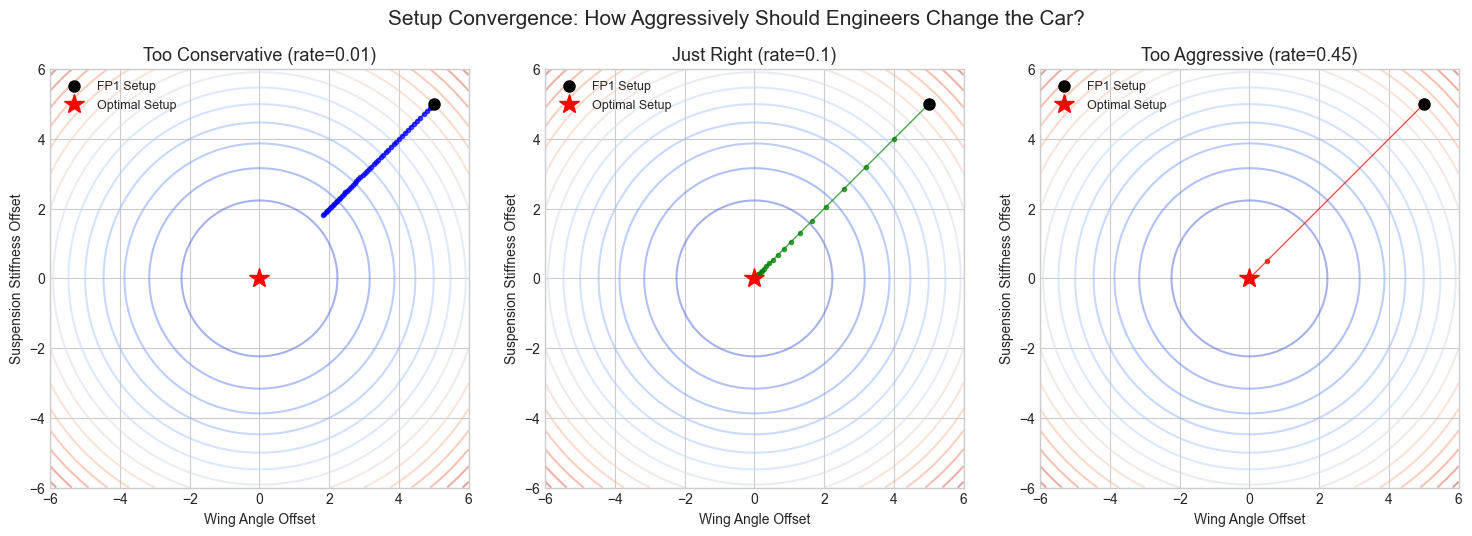

In [3]:
# Visualize setup convergence for different adjustment aggressiveness
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

lap_time_surface, lap_time_gradient = make_quadratic(A_balanced)

setup_change_rates = [0.01, 0.1, 0.45]
titles = ['Too Conservative (rate=0.01)', 'Just Right (rate=0.1)', 'Too Aggressive (rate=0.45)']
colors = ['blue', 'green', 'red']

for ax, rate, title, color in zip(axes, setup_change_rates, titles, colors):
    hist = gradient_descent(lap_time_gradient, setup0, rate, 50, f=lap_time_surface)

    # Plot lap time contours (performance surface)
    xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    zz = np.array([lap_time_surface(np.array([xi, yi])) for xi, yi in zip(xx.ravel(), yy.ravel())]).reshape(xx.shape)
    ax.contour(xx, yy, zz, levels=15, alpha=0.5, cmap='coolwarm')

    # Plot setup trajectory across sessions
    traj = hist['x']
    ax.plot(traj[:, 0], traj[:, 1], 'o-', color=color, markersize=3, linewidth=1, alpha=0.7)
    ax.plot(traj[0, 0], traj[0, 1], 'ko', markersize=8, label='FP1 Setup')
    ax.plot(0, 0, 'r*', markersize=15, label='Optimal Setup')

    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Wing Angle Offset')
    ax.set_ylabel('Suspension Stiffness Offset')
    ax.legend(fontsize=9)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_aspect('equal')

plt.suptitle('Setup Convergence: How Aggressively Should Engineers Change the Car?', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

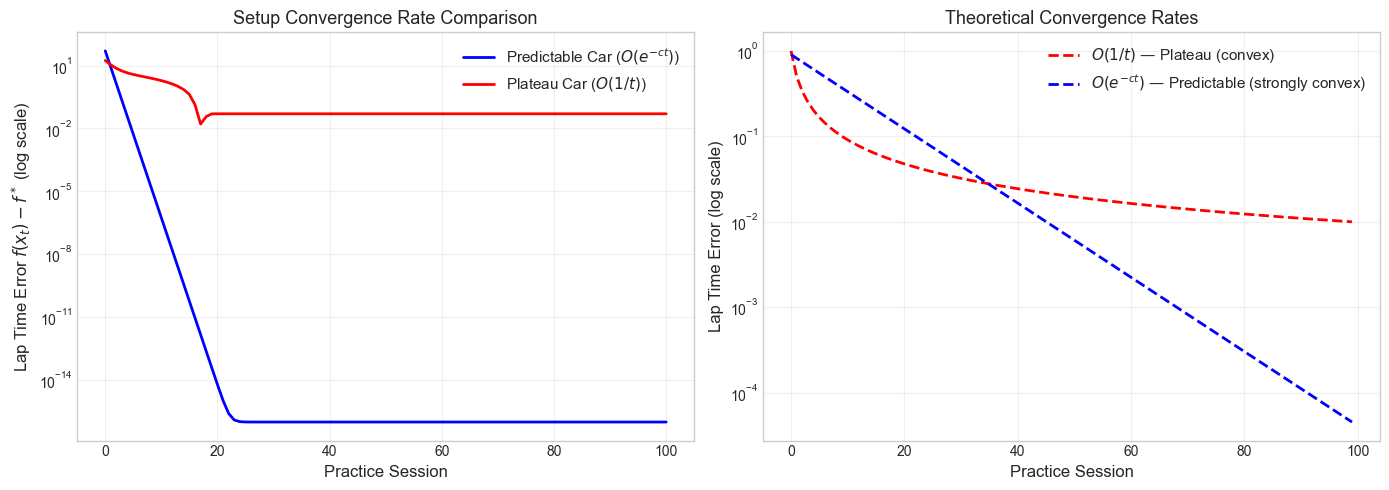

After 100 practice sessions:
  Predictable car (strongly convex) error: 1.29e-78
  Plateau car (convex) error:              5.00e-02


In [4]:
# Compare convergence rates: predictable car vs unpredictable car
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strongly convex: predictable car — setup changes map cleanly to lap time improvement
f_predictable, grad_predictable = make_quadratic(A_balanced)
hist_predictable = gradient_descent(grad_predictable, setup0, 0.3, 100, f=f_predictable)

# Convex but not strongly convex: car with a flat performance plateau
# Use Huber-like: f(x) = sqrt(x1^2 + 0.01) + 0.5*x2^2
def f_plateau(x):
    return np.sqrt(x[0]**2 + 0.01) + 0.5 * x[1]**2

def grad_plateau(x):
    g1 = x[0] / np.sqrt(x[0]**2 + 0.01)
    g2 = x[1]
    return np.array([g1, g2])

hist_plateau = gradient_descent(grad_plateau, setup0, 0.3, 100, f=f_plateau)

# Plot lap time error convergence
f_star_predictable = 0.0
f_star_plateau = np.sqrt(0.01)  # minimum value

ax = axes[0]
errors_predictable = np.array(hist_predictable['f']) - f_star_predictable
errors_plateau = np.array(hist_plateau['f']) - f_star_plateau
ax.semilogy(errors_predictable + 1e-16, 'b-', linewidth=2, label='Predictable Car ($O(e^{-ct})$)')
ax.semilogy(errors_plateau + 1e-16, 'r-', linewidth=2, label='Plateau Car ($O(1/t)$)')
ax.set_xlabel('Practice Session', fontsize=12)
ax.set_ylabel('Lap Time Error $f(x_t) - f^*$ (log scale)', fontsize=12)
ax.set_title('Setup Convergence Rate Comparison', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot theoretical rates
ax = axes[1]
t = np.arange(1, 101)
ax.semilogy(1.0 / t, 'r--', linewidth=2, label='$O(1/t)$ — Plateau (convex)')
ax.semilogy(np.exp(-0.1 * t), 'b--', linewidth=2, label='$O(e^{-ct})$ — Predictable (strongly convex)')
ax.set_xlabel('Practice Session', fontsize=12)
ax.set_ylabel('Lap Time Error (log scale)', fontsize=12)
ax.set_title('Theoretical Convergence Rates', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("After 100 practice sessions:")
print(f"  Predictable car (strongly convex) error: {errors_predictable[-1]:.2e}")
print(f"  Plateau car (convex) error:              {errors_plateau[-1]:.2e}")

### Deep Dive: Choosing the Right Setup Change Rate

The optimal step size depends on the function's **Lipschitz constant** $L$ — the maximum curvature of the gradient:

$$\|\nabla f(x) - \nabla f(y)\| \leq L \|x - y\|$$

**The rule:** Set $\eta \leq 1/L$ for guaranteed convergence.

For a quadratic $f(x) = \frac{1}{2}x^T A x$, the Lipschitz constant is $L = \lambda_{\max}(A)$ (the largest eigenvalue).

**F1 analogy:** The Lipschitz constant is like the car's **setup sensitivity** — how dramatically lap time changes when you adjust a parameter. A car with high aero sensitivity (high $L$) requires smaller, more cautious changes. Push too hard and the car snaps into oversteer. A car with low sensitivity allows bolder adjustments.

| Setup Change Rate | Behavior | Convergence | F1 Parallel |
|-----------|----------|-------------|-------------|
| $\eta \ll 1/L$ | Very slow, safe | Guaranteed but wastes sessions | Conservative team — solid results but leaves time on the table |
| $\eta = 1/L$ | Optimal for GD | Fastest guaranteed convergence | Top team — pushes right to the limit of what the data says |
| $\eta > 2/L$ | Oscillates then diverges | No convergence | Over-aggressive — car goes from understeer to oversteer every session |

**What this means:** In practice, learning rate is the most important hyperparameter. Too large = training explodes. Too small = training takes forever. Learning rate schedulers (starting large, decreasing over time) try to get the best of both worlds — like an F1 team making big changes in FP1, then fine-tuning through FP3 and qualifying.

---
## 2. Convexity and Guarantees

### Intuitive Explanation

A function is **convex** if every chord lies above the curve — there are no "valleys" to get trapped in. This is the single most important property in optimization because it guarantees that any local minimum is also the *global* minimum.

**Three levels of "niceness":**

1. **Non-convex**: Multiple local minima, saddle points. No guarantees. (Most neural network losses)
2. **Convex**: One global minimum (or a flat region of minima). GD converges at $O(1/t)$.
3. **Strongly convex**: A unique global minimum with curvature bounded away from zero. GD converges exponentially.

### The F1 Connection

Think of the **performance surface** — lap time as a function of all setup parameters. A convex performance surface means there's one clear optimal setup: every direction you improve in genuinely gets you closer to the best. A non-convex surface means there are **local minima** — setups that feel optimal because small changes make things worse, but a completely different setup philosophy could be faster.

This is exactly what happens at circuits like Monaco vs Monza. At Monza (low downforce, straightforward optimization), the performance surface is nearly convex — there's one obvious setup direction. At Monaco, the tradeoffs between mechanical grip, low-speed aero, and ride height create a much more complex, non-convex landscape with multiple local optima.

**What this means:** Strongly convex is the "easy mode" of optimization. Convex is "medium." Non-convex is "hard mode" — and it's where deep learning lives.

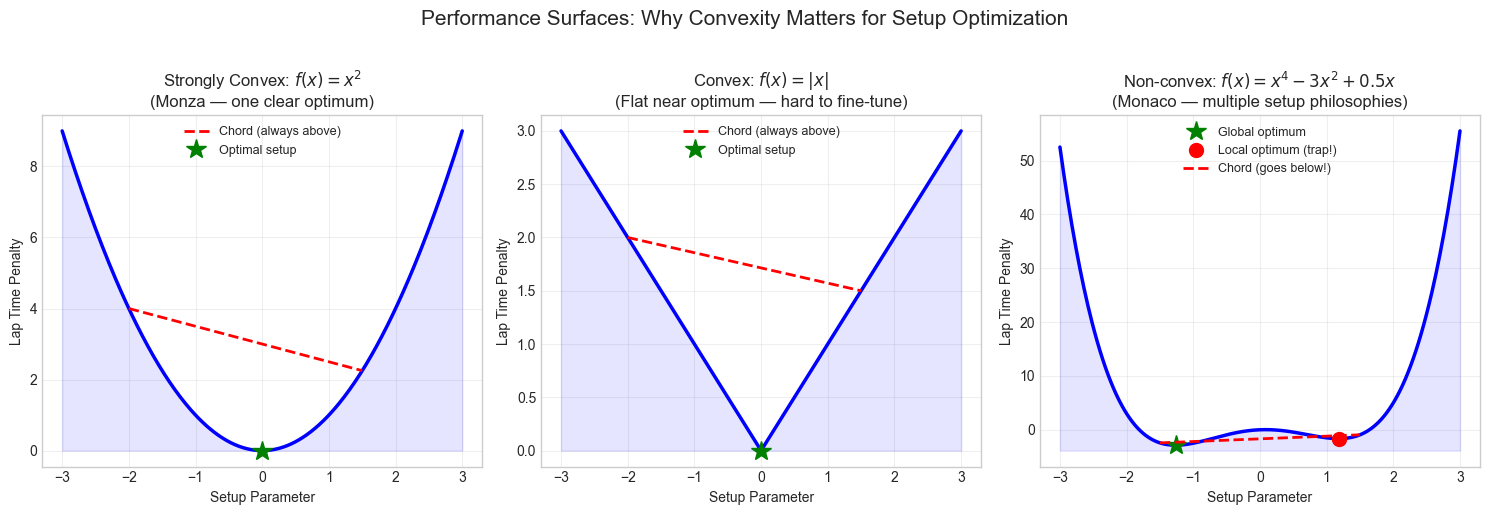

In [5]:
# Visualize three types of performance surfaces
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.linspace(-3, 3, 300)

# Strongly convex: f(x) = x^2 — like Monza setup optimization
ax = axes[0]
y = x**2
ax.plot(x, y, 'b-', linewidth=2.5)
ax.fill_between(x, y, alpha=0.1, color='blue')
# Show chord above curve
x1, x2 = -2, 1.5
ax.plot([x1, x2], [x1**2, x2**2], 'r--', linewidth=2, label='Chord (always above)')
ax.plot(0, 0, 'g*', markersize=15, label='Optimal setup')
ax.set_title('Strongly Convex: $f(x) = x^2$\n(Monza — one clear optimum)', fontsize=12)
ax.set_xlabel('Setup Parameter')
ax.set_ylabel('Lap Time Penalty')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Convex but not strongly: f(x) = |x| — flat plateau near optimum
ax = axes[1]
y = np.abs(x)
ax.plot(x, y, 'b-', linewidth=2.5)
ax.fill_between(x, y, alpha=0.1, color='blue')
x1, x2 = -2, 1.5
ax.plot([x1, x2], [abs(x1), abs(x2)], 'r--', linewidth=2, label='Chord (always above)')
ax.plot(0, 0, 'g*', markersize=15, label='Optimal setup')
ax.set_title('Convex: $f(x) = |x|$\n(Flat near optimum — hard to fine-tune)', fontsize=12)
ax.set_xlabel('Setup Parameter')
ax.set_ylabel('Lap Time Penalty')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Non-convex: f(x) = x^4 - 3x^2 + x — like Monaco with multiple local optima
ax = axes[2]
y = x**4 - 3*x**2 + 0.5*x
ax.plot(x, y, 'b-', linewidth=2.5)
ax.fill_between(x, y, y.min()-1, alpha=0.1, color='blue')
# Find and mark local minima
from scipy.optimize import minimize_scalar
res1 = minimize_scalar(lambda t: t**4 - 3*t**2 + 0.5*t, bounds=(-2, 0), method='bounded')
res2 = minimize_scalar(lambda t: t**4 - 3*t**2 + 0.5*t, bounds=(0, 2), method='bounded')
ax.plot(res1.x, res1.fun, 'g*', markersize=15, label=f'Global optimum')
ax.plot(res2.x, res2.fun, 'ro', markersize=10, label=f'Local optimum (trap!)')
# Show chord below curve (non-convex!)
x1, x2 = -1.5, 1.5
fx1 = x1**4 - 3*x1**2 + 0.5*x1
fx2 = x2**4 - 3*x2**2 + 0.5*x2
ax.plot([x1, x2], [fx1, fx2], 'r--', linewidth=2, label='Chord (goes below!)')
ax.set_title('Non-convex: $f(x) = x^4 - 3x^2 + 0.5x$\n(Monaco — multiple setup philosophies)', fontsize=12)
ax.set_xlabel('Setup Parameter')
ax.set_ylabel('Lap Time Penalty')
ax.legend(fontsize=9, loc='upper center')
ax.grid(True, alpha=0.3)

plt.suptitle('Performance Surfaces: Why Convexity Matters for Setup Optimization', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

### Deep Dive: Condition Number

The **condition number** $\kappa = \lambda_{\max} / \lambda_{\min}$ measures how "stretched" a function's contours are.

- $\kappa = 1$: Perfect circles — GD goes straight to the minimum
- $\kappa \gg 1$: Elongated ellipses — GD zigzags painfully

**F1 analogy:** The condition number measures how **unbalanced** the car's sensitivity is across setup dimensions. A well-balanced car ($\kappa \approx 1$) responds equally to wing angle and suspension changes — engineers can optimize both simultaneously. A poorly balanced car ($\kappa \gg 1$) is extremely sensitive to one parameter (say, ride height) but barely responds to another (say, toe angle). This forces the engineers into a frustrating zigzag: they fix ride height, which throws off the now-sensitive balance, then fix balance, which throws off ride height.

**Why it matters in ML:**

| Situation | Effect | F1 Parallel |
|-----------|--------|-------------|
| Poorly scaled features | High condition number, slow training | Unbalanced car — one parameter dominates |
| Batch normalization | Reduces effective condition number | Re-balancing the car mid-session |
| Adam optimizer | Adapts per-parameter, handles ill-conditioning | Separate engineers tuning each subsystem |
| Feature normalization | Reduces condition number before training | Baseline setup that starts balanced |

**Key insight:** The convergence rate of GD on strongly convex functions is $O\left(\left(\frac{\kappa - 1}{\kappa + 1}\right)^t\right)$. When $\kappa = 1$, this is $0^t$ — instant convergence. When $\kappa = 100$, convergence is painfully slow.

<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/2788462551.py:5: SyntaxWarning: invalid escape sequence '\k'
  titles = ['$\kappa = 1$ (perfectly balanced car)', '$\kappa = 5$ (moderately unbalanced)', '$\kappa = 20$ (badly unbalanced)']
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/2788462551.py:5: SyntaxWarning: invalid escape sequence '\k'
  titles = ['$\kappa = 1$ (perfectly balanced car)', '$\kappa = 5$ (moderately unbalanced)', '$\kappa = 20$ (badly unbalanced)']
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/2788462551.py:5: SyntaxWarning: invalid escape sequence '\k'
  titles = ['$\kappa = 1$ (perfectly balanced car)', '$\kappa = 5$ 

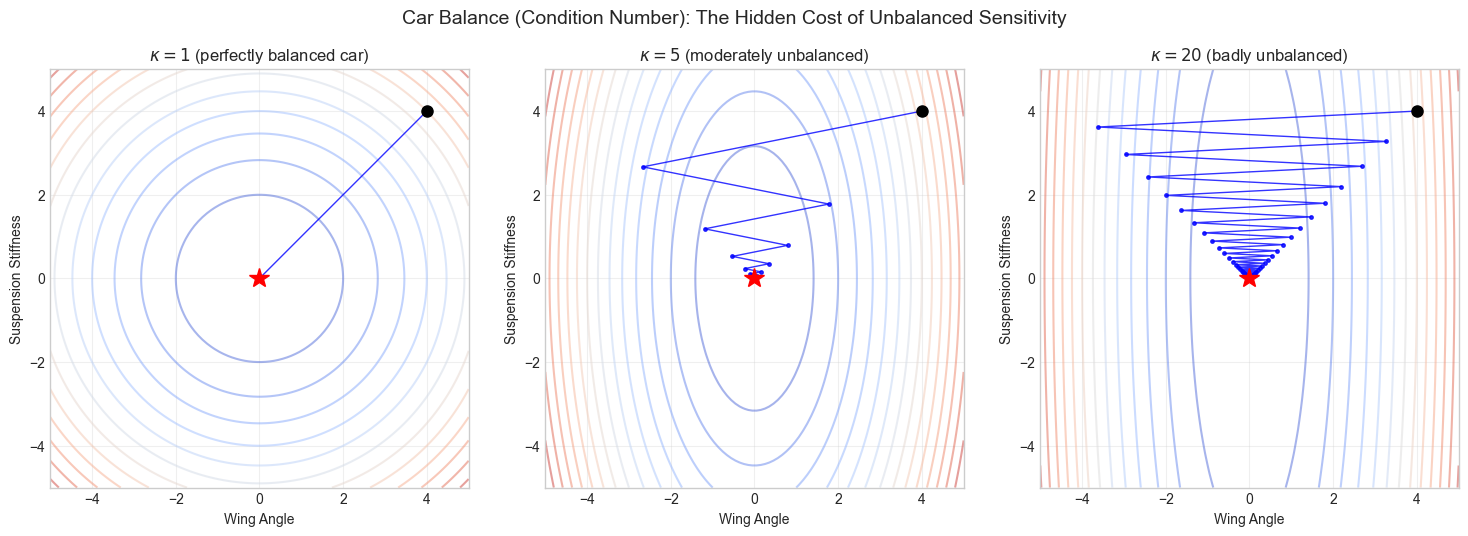

Sessions to reach lap time error < 0.01:
  kappa= 1: 1 sessions
  kappa= 5: 11 sessions
  kappa=20: 49 sessions


In [6]:
# Visualize effect of car balance (condition number) on setup convergence paths
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

condition_numbers = [1, 5, 20]
titles = ['$\kappa = 1$ (perfectly balanced car)', '$\kappa = 5$ (moderately unbalanced)', '$\kappa = 20$ (badly unbalanced)']

for ax, kappa, title in zip(axes, condition_numbers, titles):
    A = np.array([[kappa, 0.0], [0.0, 1.0]])
    f, grad_f = make_quadratic(A)

    # Optimal step size: 2 / (lambda_max + lambda_min)
    setup_rate = 2.0 / (kappa + 1.0)
    hist = gradient_descent(grad_f, np.array([4.0, 4.0]), setup_rate, 50, f=f)

    # Performance surface contours
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    zz = np.array([f(np.array([xi, yi])) for xi, yi in zip(xx.ravel(), yy.ravel())]).reshape(xx.shape)
    ax.contour(xx, yy, zz, levels=15, alpha=0.5, cmap='coolwarm')

    # Setup trajectory
    traj = hist['x']
    ax.plot(traj[:, 0], traj[:, 1], 'b.-', markersize=5, linewidth=1, alpha=0.8)
    ax.plot(traj[0, 0], traj[0, 1], 'ko', markersize=8)
    ax.plot(0, 0, 'r*', markersize=15)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Wing Angle')
    ax.set_ylabel('Suspension Stiffness')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Car Balance (Condition Number): The Hidden Cost of Unbalanced Sensitivity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Sessions to reach lap time error < 0.01:")
for kappa in condition_numbers:
    A = np.array([[kappa, 0.0], [0.0, 1.0]])
    f, grad_f = make_quadratic(A)
    setup_rate = 2.0 / (kappa + 1.0)
    hist = gradient_descent(grad_f, np.array([4.0, 4.0]), setup_rate, 500, f=f)
    for i, fval in enumerate(hist['f']):
        if fval < 0.01:
            print(f"  kappa={kappa:2d}: {i} sessions")
            break
    else:
        print(f"  kappa={kappa:2d}: >500 sessions")

---
## 3. Stochastic Gradient Descent

### Intuitive Explanation

In machine learning, the objective is usually a sum over data points:

$$f(w) = \frac{1}{N}\sum_{i=1}^{N} \ell(w; x_i, y_i)$$

**Full gradient descent** computes the gradient using *all* $N$ data points — expensive when $N$ is millions.

**Stochastic gradient descent (SGD)** approximates the gradient using a single random data point (or a small mini-batch). The gradient estimate is noisy but *unbiased*:

$$\mathbb{E}[\nabla \ell(w; x_i, y_i)] = \nabla f(w)$$

### The F1 Connection

Think of the difference between **learning from individual laps vs. averaging over a full session**:

- **Full GD** = waiting until the end of a full practice session, averaging telemetry across all laps, then making one big setup change. Accurate but slow — you only get 3 practice sessions before qualifying.
- **SGD** = making small adjustments after *every single lap* based on that lap's data alone. Noisy (one lap might have traffic or a mistake) but you iterate much faster.
- **Mini-batch SGD** = analyzing a **stint** (a group of laps on the same tires) — a practical middle ground between one lap and the full session.

**Why stochasticity helps:**
1. **Computational efficiency**: Each step is $O(1)$ instead of $O(N)$
2. **Escaping saddle points**: Noise helps SGD escape flat regions where GD gets stuck
3. **Implicit regularization**: The noise acts as a regularizer, improving generalization

**The tradeoff:** SGD steps are cheaper but noisier. Mini-batches balance this — larger batches reduce variance but cost more compute.

In [7]:
def sgd(lap_grad, setup0, setup_rate, n_sessions, n_laps, stint_size=1, f=None):
    """
    Stochastic gradient descent with mini-batches.
    (F1: Learning from individual laps or stints instead of full sessions.)

    Args:
        lap_grad: Function(setup, lap_indices) returning gradient estimate from a subset of laps
        setup0: Initial car setup
        setup_rate: Learning rate (can be a function of session t)
        n_sessions: Number of iterations
        n_laps: Total number of laps in the dataset
        stint_size: Mini-batch size (number of laps per stint)
        f: Optional full objective function for tracking

    Returns:
        history dict with setup trajectory and lap time errors
    """
    setup = np.array(setup0, dtype=float)
    history = {'x': [setup.copy()], 'f': []}

    if f is not None:
        history['f'].append(f(setup))

    for t in range(n_sessions):
        # Sample a stint (mini-batch of laps)
        lap_indices = np.random.choice(n_laps, size=stint_size, replace=False)

        # Setup change rate schedule
        current_rate = setup_rate(t) if callable(setup_rate) else setup_rate

        g = lap_grad(setup, lap_indices)
        setup = setup - current_rate * g
        history['x'].append(setup.copy())
        if f is not None:
            history['f'].append(f(setup))

    history['x'] = np.array(history['x'])
    return history

# Create a synthetic lap time prediction problem: f(w) = (1/N) sum_i (w^T x_i - y_i)^2
# Each data point is a lap with telemetry features, and we're predicting lap time
np.random.seed(42)
N = 200  # Total laps in dataset
d = 2    # Setup dimensions (e.g., wing angle, suspension stiffness)
X_telemetry = np.random.randn(N, d)
setup_true = np.array([3.0, -1.0])  # True optimal setup mapping
y_laptimes = X_telemetry @ setup_true + 0.3 * np.random.randn(N)

def full_lap_error(setup):
    """Lap time error averaged over all laps (full session analysis)."""
    residuals = X_telemetry @ setup - y_laptimes
    return np.mean(residuals**2)

def full_grad(setup):
    """Gradient from all laps (full session)."""
    residuals = X_telemetry @ setup - y_laptimes
    return 2.0 * X_telemetry.T @ residuals / N

def stint_grad(setup, lap_indices):
    """Gradient from a stint (subset of laps)."""
    X_stint = X_telemetry[lap_indices]
    y_stint = y_laptimes[lap_indices]
    residuals = X_stint @ setup - y_stint
    return 2.0 * X_stint.T @ residuals / len(lap_indices)

setup_init = np.array([0.0, 0.0])  # Starting from baseline setup
print(f"True optimal setup: {setup_true}")
print(f"Initial lap time error: {full_lap_error(setup_init):.4f}")

True optimal setup: [ 3. -1.]
Initial lap time error: 9.4693


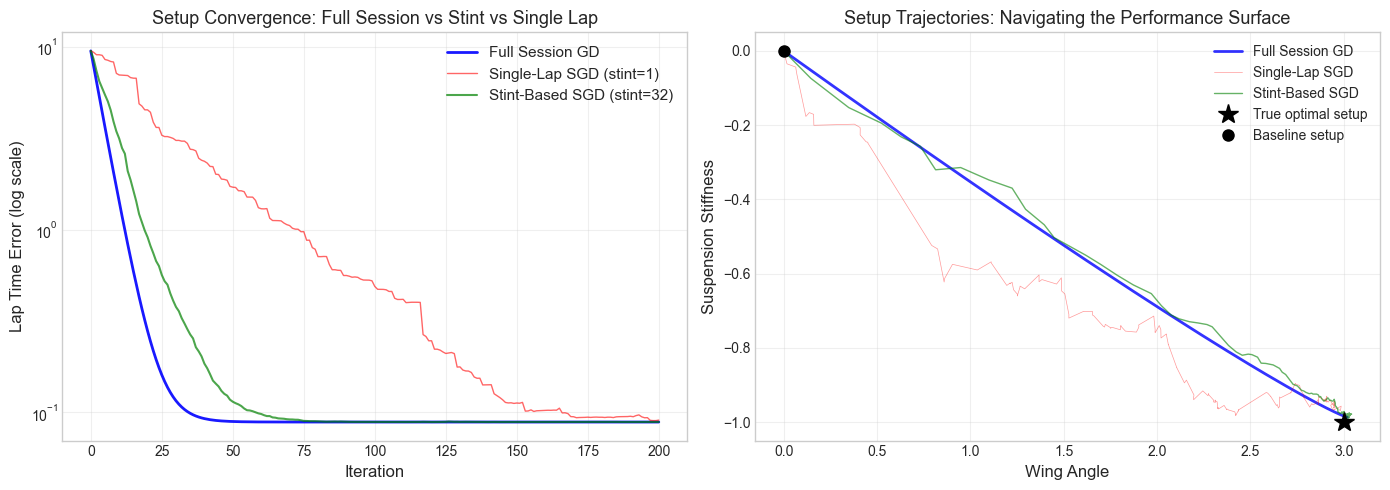


Final setups found:
  Full Session:   [3.0196, -0.9871]
  Single-Lap:     [2.9759, -0.9666]
  Stint (B=32):   [3.0187, -0.9944]
  True optimal:   [3.0000, -1.0000]


In [8]:
# Compare Full Session Analysis vs Single-Lap vs Stint-Based Learning
np.random.seed(42)
n_sessions = 200

# Full session GD (analyze all laps, then adjust)
hist_full = gradient_descent(full_grad, setup_init, 0.05, n_sessions, f=full_lap_error)

# Single-lap SGD (adjust after each lap — noisy but fast)
np.random.seed(42)
hist_single_lap = sgd(stint_grad, setup_init, 0.01, n_sessions, N, stint_size=1, f=full_lap_error)

# Stint-based SGD (analyze a stint of 32 laps, then adjust)
np.random.seed(42)
hist_stint = sgd(stint_grad, setup_init, 0.03, n_sessions, N, stint_size=32, f=full_lap_error)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lap time error curves
ax = axes[0]
ax.semilogy(hist_full['f'], 'b-', linewidth=2, label='Full Session GD', alpha=0.9)
ax.semilogy(hist_single_lap['f'], 'r-', linewidth=1, label='Single-Lap SGD (stint=1)', alpha=0.6)
ax.semilogy(hist_stint['f'], 'g-', linewidth=1.5, label='Stint-Based SGD (stint=32)', alpha=0.7)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Lap Time Error (log scale)', fontsize=12)
ax.set_title('Setup Convergence: Full Session vs Stint vs Single Lap', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Trajectories in setup space
ax = axes[1]
ax.plot(hist_full['x'][:, 0], hist_full['x'][:, 1], 'b-', linewidth=2, label='Full Session GD', alpha=0.8)
ax.plot(hist_single_lap['x'][:, 0], hist_single_lap['x'][:, 1], 'r-', linewidth=0.5, label='Single-Lap SGD', alpha=0.4)
ax.plot(hist_stint['x'][:, 0], hist_stint['x'][:, 1], 'g-', linewidth=1, label='Stint-Based SGD', alpha=0.6)
ax.plot(setup_true[0], setup_true[1], 'k*', markersize=15, label='True optimal setup', zorder=5)
ax.plot(setup_init[0], setup_init[1], 'ko', markersize=8, label='Baseline setup')
ax.set_xlabel('Wing Angle', fontsize=12)
ax.set_ylabel('Suspension Stiffness', fontsize=12)
ax.set_title('Setup Trajectories: Navigating the Performance Surface', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal setups found:")
print(f"  Full Session:   [{hist_full['x'][-1][0]:.4f}, {hist_full['x'][-1][1]:.4f}]")
print(f"  Single-Lap:     [{hist_single_lap['x'][-1][0]:.4f}, {hist_single_lap['x'][-1][1]:.4f}]")
print(f"  Stint (B=32):   [{hist_stint['x'][-1][0]:.4f}, {hist_stint['x'][-1][1]:.4f}]")
print(f"  True optimal:   [{setup_true[0]:.4f}, {setup_true[1]:.4f}]")

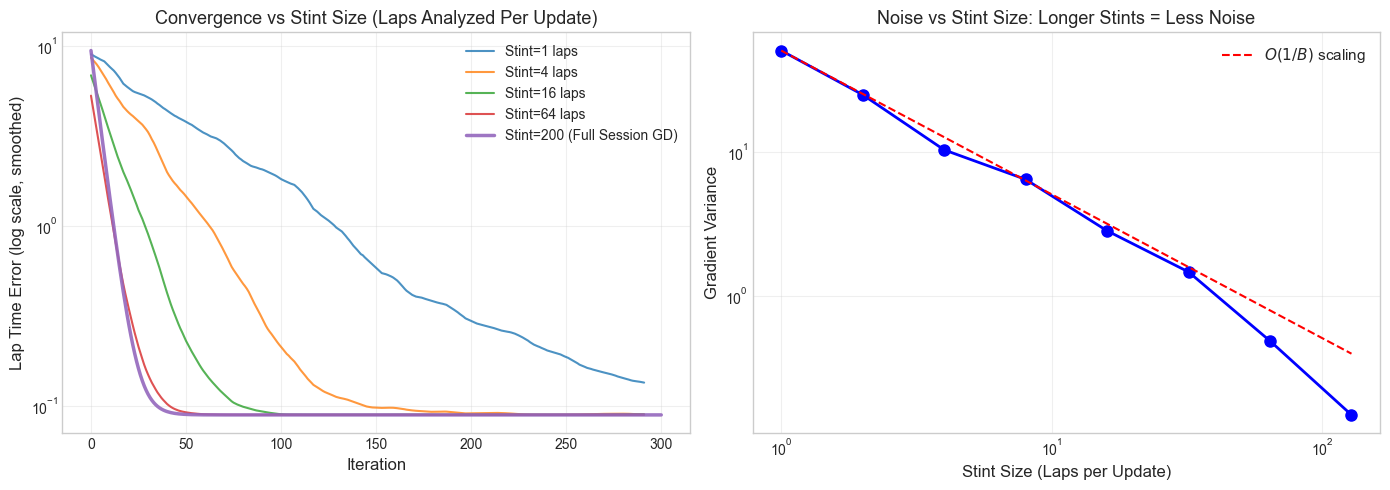

Key insight: Gradient variance scales as O(1/B)
Doubling stint size halves the noise but doubles compute per update


In [9]:
# Stint size tradeoff: how many laps to analyze before adjusting setup
np.random.seed(42)
stint_sizes = [1, 4, 16, 64, N]
n_sessions_per = 300

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Adjust setup change rates for each stint size
rate_map = {1: 0.005, 4: 0.01, 16: 0.02, 64: 0.04, N: 0.05}

for bs in stint_sizes:
    np.random.seed(42)
    rate = rate_map[bs]
    label = f'Stint={bs} laps' if bs < N else f'Stint={N} (Full Session GD)'
    if bs == N:
        hist = gradient_descent(full_grad, setup_init, rate, n_sessions_per, f=full_lap_error)
    else:
        hist = sgd(stint_grad, setup_init, rate, n_sessions_per, N, stint_size=bs, f=full_lap_error)

    # Smooth the SGD curves for visibility
    fvals = np.array(hist['f'])
    if bs < N:
        # Moving average
        window = max(1, 10)
        fvals_smooth = np.convolve(fvals, np.ones(window)/window, mode='valid')
        axes[0].semilogy(fvals_smooth, linewidth=1.5, label=label, alpha=0.8)
    else:
        axes[0].semilogy(fvals, linewidth=2.5, label=label, alpha=0.9)

axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Lap Time Error (log scale, smoothed)', fontsize=12)
axes[0].set_title('Convergence vs Stint Size (Laps Analyzed Per Update)', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Variance of gradient estimates across stints
ax = axes[1]
stint_range = [1, 2, 4, 8, 16, 32, 64, 128]
grad_variances = []
setup_test = np.array([1.0, 1.0])

for bs in stint_range:
    grads = []
    for _ in range(200):
        idx = np.random.choice(N, size=bs, replace=False)
        g = stint_grad(setup_test, idx)
        grads.append(g)
    grads = np.array(grads)
    grad_variances.append(np.mean(np.var(grads, axis=0)))

ax.loglog(stint_range, grad_variances, 'bo-', linewidth=2, markersize=8)
ax.loglog(stint_range, grad_variances[0] / np.array(stint_range), 'r--', linewidth=1.5, label='$O(1/B)$ scaling')
ax.set_xlabel('Stint Size (Laps per Update)', fontsize=12)
ax.set_ylabel('Gradient Variance', fontsize=12)
ax.set_title('Noise vs Stint Size: Longer Stints = Less Noise', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Gradient variance scales as O(1/B)")
print("Doubling stint size halves the noise but doubles compute per update")

### Deep Dive: Why SGD Works So Well in Practice

SGD's noise is not just a computational shortcut — it's a *feature*:

1. **Escaping sharp minima**: SGD's noise bounces it out of sharp, narrow minima and into flatter ones. Flat minima tend to generalize better (the loss doesn't change much if weights shift slightly).

2. **Implicit regularization**: SGD with a finite learning rate implicitly prefers solutions with smaller norms. This acts like free regularization.

3. **Exploration**: Early in training, large noise helps explore the loss landscape. Late in training, we want less noise — hence learning rate decay.

**F1 analogy:** Think of SGD's noise as **changing track conditions** — wind gusts, rubber buildup, fuel load changes. A setup that works under all those perturbations (flat minimum) will be more robust on race day than a setup that's perfect in one specific condition but falls apart otherwise. Teams that learn from noisy lap data build more robust setups than teams that only look at their one perfect qualifying simulation lap.

| Technique | Purpose | Effect | F1 Parallel |
|-----------|---------|--------|-------------|
| Learning rate warmup | Avoid early instability | Start small, increase to target LR | Installation laps before pushing |
| Learning rate decay | Converge precisely | Reduce noise late in training | Fine-tuning in FP3 after big FP1 changes |
| Momentum | Smooth out noise | Average gradients over time | Keeping changes in the direction that's been working |
| Adam | Adapt per-parameter | Handle different scales automatically | Different engineers tuning each subsystem independently |

**Common misconception:** "SGD is just a noisy version of GD." *Reality:* SGD finds qualitatively different (often better) solutions than GD because the noise structure matters.

---
## 4. The Bias-Variance Tradeoff

### Intuitive Explanation

When we train a model, we want it to generalize — to perform well on *new* data, not just the training data. The **bias-variance decomposition** tells us exactly what can go wrong:

$$\text{Expected Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Noise}$$

### The F1 Connection

This tradeoff shows up directly in car setup philosophy:

- **High bias (conservative setup)**: A setup that works reasonably everywhere — decent in corners, decent on straights, decent in the wet. It never embarrasses you, but it never excels either. This is the midfield "safe" approach.
- **High variance (specialized setup)**: A setup optimized for one specific sector or condition. Blazing fast through Maggotts-Becketts at Silverstone, but a handful through Copse. Different practice sessions give wildly different results.
- **Irreducible noise**: Track conditions you can't control — wind, temperature, safety car timing. No setup eliminates this.

| Component | Meaning | Caused By | F1 Parallel |
|-----------|---------|-----------|-------------|
| **Bias**$^2$ | How far off the average prediction is from truth | Model too simple (underfitting) | Conservative setup — safe but slow |
| **Variance** | How much predictions change across different training sets | Model too complex (overfitting) | Specialized setup — fast in practice, unpredictable in race |
| **Irreducible noise** | Inherent randomness in the data | Nothing — this is the floor | Weather, safety cars, track evolution |

**What this means:** You can't minimize both bias and variance simultaneously. Simple models have high bias but low variance. Complex models have low bias but high variance. The sweet spot is in the middle — like a setup that's optimized but still robust.

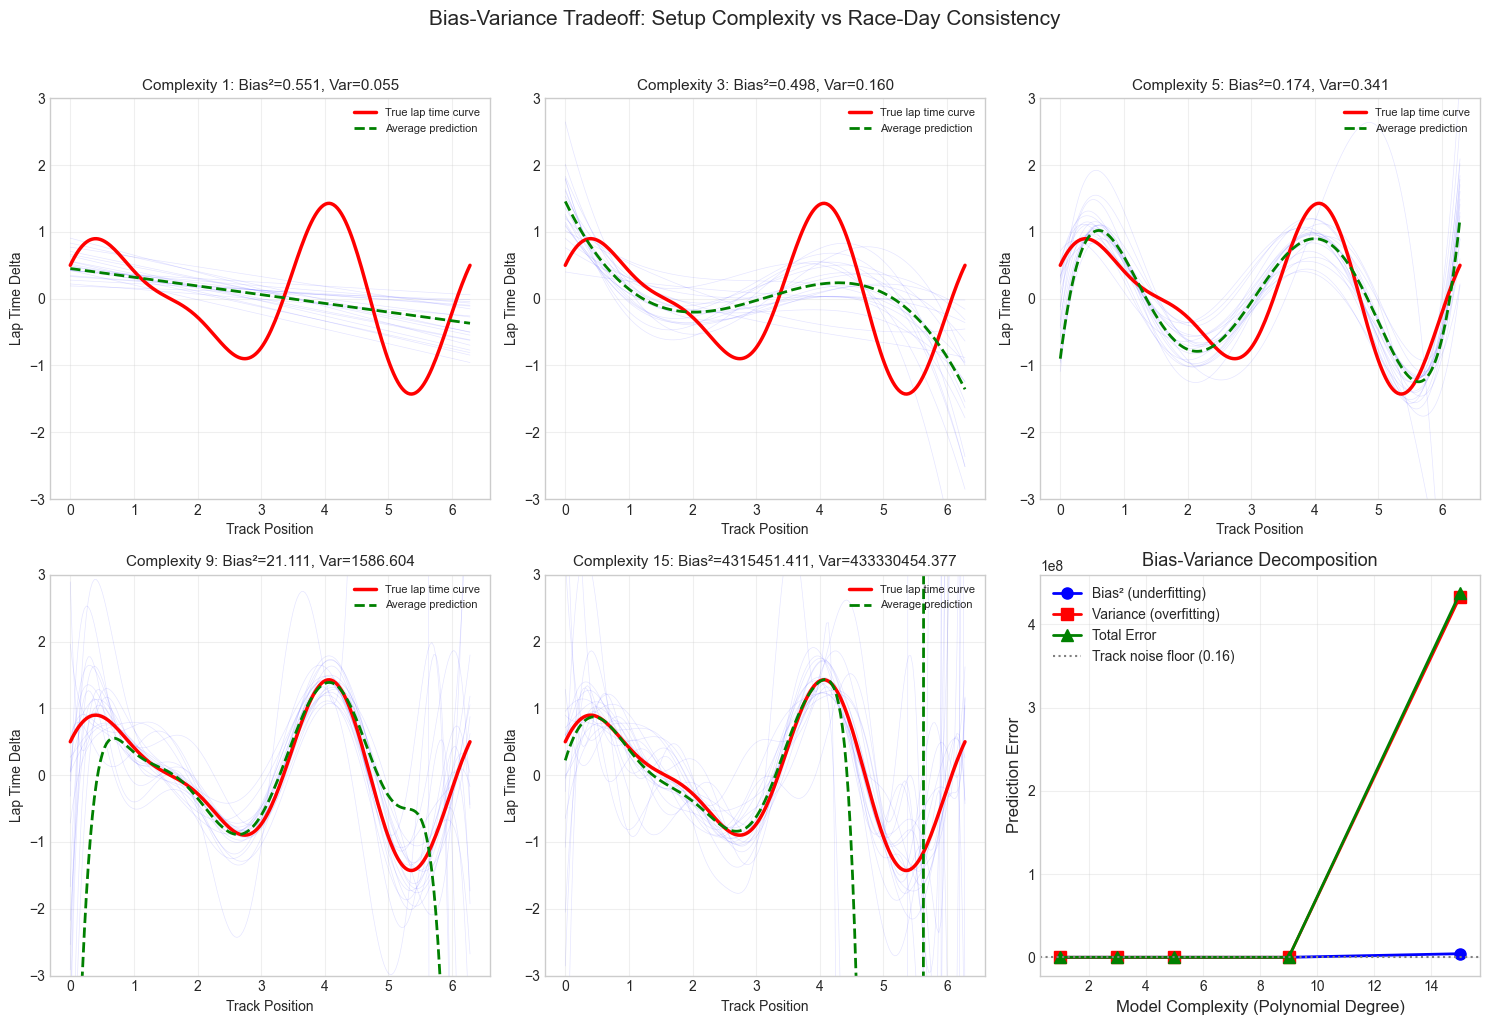

In [10]:
# Demonstrate bias-variance tradeoff with polynomial lap time models
np.random.seed(42)

# True lap time function (what we're trying to predict)
def true_laptime(x):
    return np.sin(2 * x) + 0.5 * np.cos(3 * x)

# Generate multiple race weekends and fit models of different complexity
n_laps_train = 25
n_weekends = 100
noise_std = 0.4
x_test = np.linspace(0, 2*np.pi, 200)
y_true = true_laptime(x_test)

# Model complexity: from simple (linear) to complex (high-degree polynomial)
complexities = [1, 3, 5, 9, 15]
predictions = {d: [] for d in complexities}

for _ in range(n_weekends):
    x_train = np.random.uniform(0, 2*np.pi, n_laps_train)
    y_train = true_laptime(x_train) + noise_std * np.random.randn(n_laps_train)

    for d in complexities:
        poly = PolynomialFeatures(d)
        X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
        X_test_poly = poly.transform(x_test.reshape(-1, 1))

        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
        predictions[d].append(y_pred)

# Compute bias^2 and variance
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, d in enumerate(complexities[:5]):
    row, col = divmod(idx, 3)
    ax = axes[row][col]

    preds = np.array(predictions[d])
    mean_pred = preds.mean(axis=0)

    # Plot predictions from individual weekends (sample of 20)
    for i in range(min(20, n_weekends)):
        ax.plot(x_test, preds[i], 'b-', alpha=0.1, linewidth=0.5)

    ax.plot(x_test, y_true, 'r-', linewidth=2.5, label='True lap time curve')
    ax.plot(x_test, mean_pred, 'g--', linewidth=2, label='Average prediction')

    bias_sq = np.mean((mean_pred - y_true)**2)
    variance = np.mean(np.var(preds, axis=0))

    ax.set_title(f'Complexity {d}: Bias²={bias_sq:.3f}, Var={variance:.3f}', fontsize=11)
    ax.set_xlabel('Track Position')
    ax.set_ylabel('Lap Time Delta')
    ax.legend(fontsize=8, loc='upper right')
    ax.set_ylim(-3, 3)
    ax.grid(True, alpha=0.3)

# Use last subplot for the decomposition summary
ax = axes[1][2]
biases_sq = []
variances = []
for d in complexities:
    preds = np.array(predictions[d])
    mean_pred = preds.mean(axis=0)
    biases_sq.append(np.mean((mean_pred - y_true)**2))
    variances.append(np.mean(np.var(preds, axis=0)))

total = np.array(biases_sq) + np.array(variances) + noise_std**2
ax.plot(complexities, biases_sq, 'bo-', linewidth=2, label='Bias² (underfitting)', markersize=8)
ax.plot(complexities, variances, 'rs-', linewidth=2, label='Variance (overfitting)', markersize=8)
ax.plot(complexities, total, 'g^-', linewidth=2, label='Total Error', markersize=8)
ax.axhline(y=noise_std**2, color='gray', linestyle=':', linewidth=1.5, label=f'Track noise floor ({noise_std**2:.2f})')
ax.set_xlabel('Model Complexity (Polynomial Degree)', fontsize=12)
ax.set_ylabel('Prediction Error', fontsize=12)
ax.set_title('Bias-Variance Decomposition', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Bias-Variance Tradeoff: Setup Complexity vs Race-Day Consistency', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

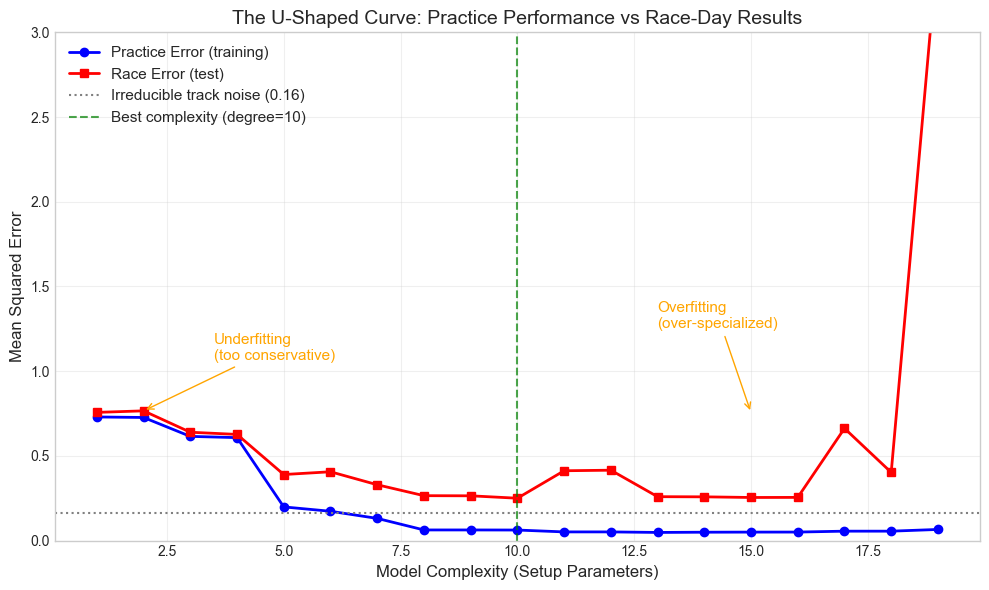

Best model complexity: degree 10
Practice error at best: 0.0618
Race error at best:     0.2496


In [11]:
# The classic U-shaped race performance curve
np.random.seed(42)
n_practice_laps = 30
n_race_laps = 200

x_practice = np.random.uniform(0, 2*np.pi, n_practice_laps)
y_practice = true_laptime(x_practice) + noise_std * np.random.randn(n_practice_laps)
x_race = np.random.uniform(0, 2*np.pi, n_race_laps)
y_race = true_laptime(x_race) + noise_std * np.random.randn(n_race_laps)

complexities_range = range(1, 20)
practice_errors = []
race_errors = []

for d in complexities_range:
    poly = PolynomialFeatures(d)
    X_pr = poly.fit_transform(x_practice.reshape(-1, 1))
    X_rc = poly.transform(x_race.reshape(-1, 1))

    model = LinearRegression()
    model.fit(X_pr, y_practice)

    practice_errors.append(np.mean((model.predict(X_pr) - y_practice)**2))
    race_errors.append(np.mean((model.predict(X_rc) - y_race)**2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(list(complexities_range), practice_errors, 'b-o', linewidth=2, markersize=6, label='Practice Error (training)')
ax.plot(list(complexities_range), race_errors, 'r-s', linewidth=2, markersize=6, label='Race Error (test)')
ax.axhline(y=noise_std**2, color='gray', linestyle=':', linewidth=1.5, label=f'Irreducible track noise ({noise_std**2:.2f})')

# Mark the sweet spot
best_complexity = list(complexities_range)[np.argmin(race_errors)]
ax.axvline(x=best_complexity, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Best complexity (degree={best_complexity})')

# Annotations
ax.annotate('Underfitting\n(too conservative)', xy=(2, race_errors[1]), fontsize=11, color='orange',
            xytext=(3.5, race_errors[1]+0.3), arrowprops=dict(arrowstyle='->', color='orange'))
ax.annotate('Overfitting\n(over-specialized)', xy=(15, min(race_errors[-5:])+0.5), fontsize=11, color='orange',
            xytext=(13, min(race_errors[-5:])+1.0), arrowprops=dict(arrowstyle='->', color='orange'))

ax.set_xlabel('Model Complexity (Setup Parameters)', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title('The U-Shaped Curve: Practice Performance vs Race-Day Results', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0, max(race_errors[0], 3))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best model complexity: degree {best_complexity}")
print(f"Practice error at best: {practice_errors[best_complexity-1]:.4f}")
print(f"Race error at best:     {race_errors[best_complexity-1]:.4f}")

---
## 5. VC Dimension and Generalization

### Intuitive Explanation

How do we measure a model's **capacity** — its ability to fit arbitrary patterns? The **Vapnik-Chervonenkis (VC) dimension** provides a formal answer.

**Definition:** The VC dimension of a model class is the largest number of points it can **shatter** — i.e., classify correctly for *every possible* labeling of those points.

### The F1 Connection

Think of VC dimension as the **complexity needed to predict lap times**:

- **Low VC dimension (simple model)**: Predict lap time using only track length. This "model" can rank Monza vs Monaco, but can't capture the detail of individual corners.
- **High VC dimension (complex model)**: Predict lap time using every corner's radius, camber, elevation change, surface roughness, and ambient temperature. This model can memorize any set of lap times perfectly, but it might not generalize to a new circuit.

**Examples:**

| Model | VC Dimension | Intuition | F1 Parallel |
|-------|-------------|-----------|-------------|
| Linear classifier in $\mathbb{R}^d$ | $d + 1$ | Can shatter $d+1$ points in general position | Predicting from $d+1$ track features |
| Linear classifier in $\mathbb{R}^2$ | 3 | Can shatter any 3 non-collinear points | Two-feature model (track length + avg speed) |
| Polynomial of degree $k$ | $k + 1$ | Can memorize $k+1$ points exactly | Adding more telemetry channels |
| Neural net with $W$ weights | $O(W \log W)$ | Roughly proportional to parameter count | Full simulation model |
| $k$-nearest neighbors | $\infty$ | Can memorize any dataset (but doesn't generalize!) | "Just copy last year's setup" — perfect memory, poor transfer |

**What this means:** Higher VC dimension = more expressive model = needs more data to generalize reliably.

/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/2715062849.py:17: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pt[0], pt[1], c=color, marker=marker, s=150, zorder=5, edgecolors='black', linewidths=1)
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/2715062849.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pt[0], pt[1], c=color, marker=marker, s=150, zorder=5, edgecolors='black', linewidths=1)


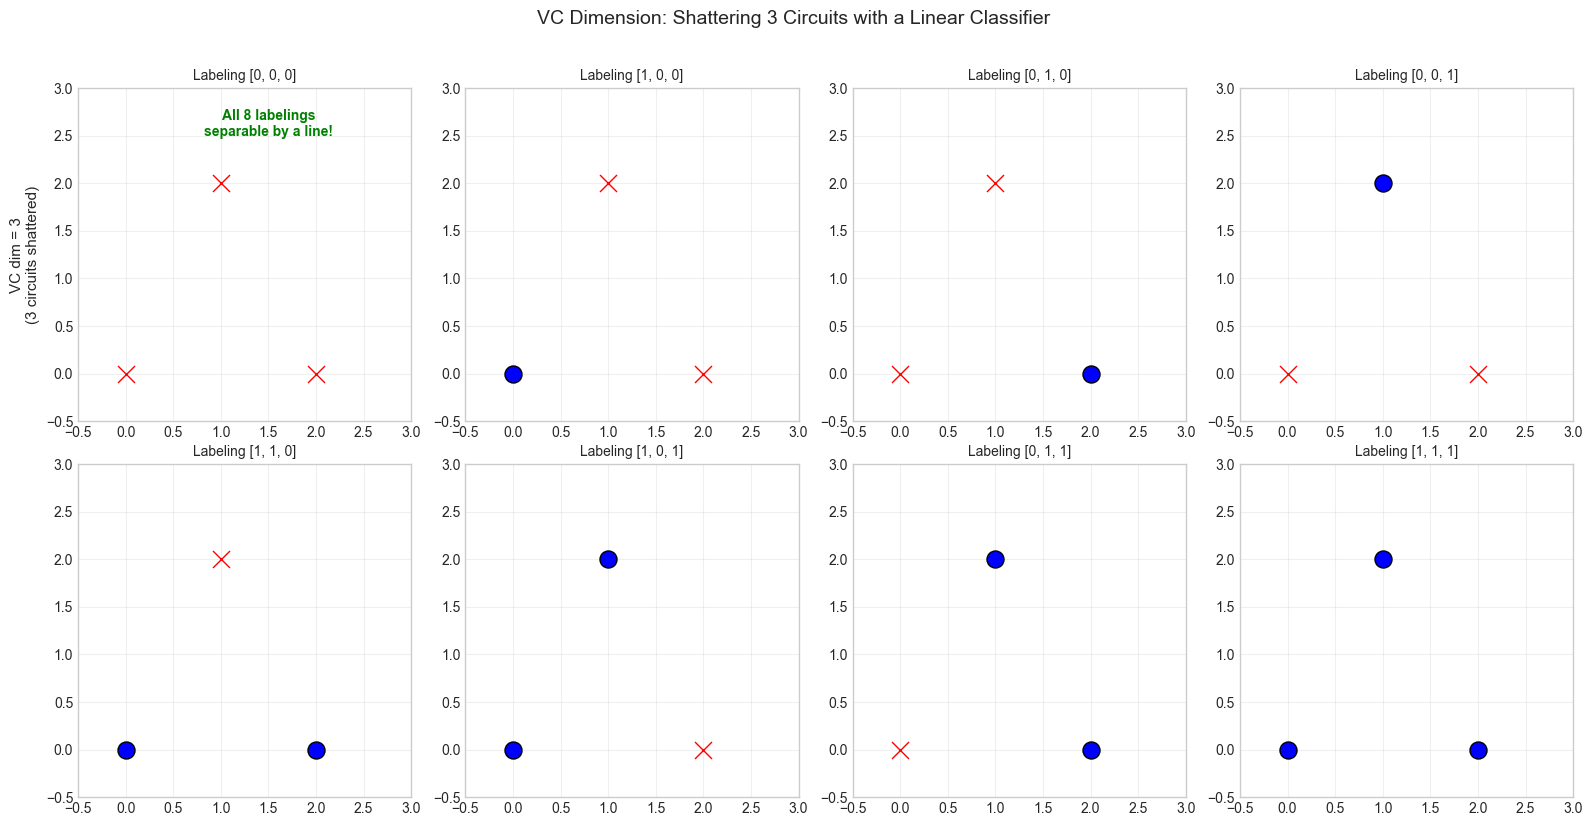

A linear classifier in R^2 has VC dimension = 3
It can shatter (perfectly classify) any 3 circuits in general position
But there exist 4 circuits (e.g., XOR-like pattern) that NO line can shatter


In [12]:
# Visualize shattering: can a simple model classify any labeling of circuits?
# A linear classifier in R^2 can shatter 3 points (circuits) but not 4

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 3 circuits in 2D feature space (e.g., track length vs avg corner speed)
circuits_3 = np.array([[0, 0], [2, 0], [1, 2]])
labelings_3 = [
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
]

for i, (ax, labels) in enumerate(zip(axes[0], labelings_3[:4])):
    for j, (pt, lab) in enumerate(zip(circuits_3, labels)):
        color = 'blue' if lab == 1 else 'red'
        marker = 'o' if lab == 1 else 'x'
        ax.scatter(pt[0], pt[1], c=color, marker=marker, s=150, zorder=5, edgecolors='black', linewidths=1)

    ax.set_xlim(-0.5, 3)
    ax.set_ylim(-0.5, 3)
    ax.set_title(f'Labeling {labels}', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_ylabel('VC dim = 3\n(3 circuits shattered)', fontsize=11)

for i, (ax, labels) in enumerate(zip(axes[1][:4], labelings_3[4:])):
    for j, (pt, lab) in enumerate(zip(circuits_3, labels)):
        color = 'blue' if lab == 1 else 'red'
        marker = 'o' if lab == 1 else 'x'
        ax.scatter(pt[0], pt[1], c=color, marker=marker, s=150, zorder=5, edgecolors='black', linewidths=1)

    ax.set_xlim(-0.5, 3)
    ax.set_ylim(-0.5, 3)
    ax.set_title(f'Labeling {labels}', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

axes[0][0].annotate('All 8 labelings\nseparable by a line!',
                      xy=(1.5, 2.5), fontsize=10, color='green',
                      ha='center', fontweight='bold')

plt.suptitle('VC Dimension: Shattering 3 Circuits with a Linear Classifier', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("A linear classifier in R^2 has VC dimension = 3")
print("It can shatter (perfectly classify) any 3 circuits in general position")
print("But there exist 4 circuits (e.g., XOR-like pattern) that NO line can shatter")

### Deep Dive: The VC Generalization Bound

The VC dimension connects model complexity to generalization through a fundamental bound:

$$\text{Test Error} \leq \text{Training Error} + O\left(\sqrt{\frac{d_{VC} \log(N/d_{VC})}{N}}\right)$$

where $d_{VC}$ is the VC dimension and $N$ is the number of training samples.

**What this tells us:**
- The gap between training and test error grows with $d_{VC}$ (model complexity)
- The gap shrinks with $N$ (more data helps)
- To keep the gap small: need $N \gg d_{VC}$

**F1 analogy:** This bound tells you how much data you need to trust your lap time model. If your model uses 50 setup parameters ($d_{VC} \approx 50$), you need hundreds of laps before you can trust that practice performance predicts race performance. If you use a simple 3-parameter model, a short stint might suffice — but it won't capture the full picture.

**Key insight:** This is the theoretical justification for the rule of thumb "you need at least 10x more data points than parameters."

#### Common Misconceptions

| Misconception | Reality |
|---------------|---------|
| "Low VC dim = good model" | Low VC dim means simple model — might underfit |
| "VC bounds are tight" | VC bounds are usually very loose; they give qualitative, not quantitative guidance |
| "More parameters = higher VC dim always" | Regularization can effectively reduce VC dimension |

---
## 6. PAC Learning

### Intuitive Explanation

**Probably Approximately Correct (PAC)** learning asks: "How much data do we need to *probably* find a model that is *approximately* correct?"

More precisely, for given:
- $\epsilon$ = accuracy tolerance ("approximately correct" — error < $\epsilon$)
- $\delta$ = confidence tolerance ("probably" — succeed with probability $\geq 1 - \delta$)

PAC learning tells us the **sample complexity**: the minimum number of training examples $N$ needed.

### The F1 Connection

PAC learning answers the question every race engineer asks: **"How many laps do we need to be confident in this setup?"**

- $\epsilon$ = how close to the true optimal lap time we need to get (say, within 0.1s)
- $\delta$ = the probability we're wrong (say, 5% chance the setup is actually bad)
- $|\mathcal{H}|$ = how many different setup configurations we're considering

If you're choosing between 10 wing angles, you need fewer laps than if you're choosing among 1000 full setup permutations. PAC theory quantifies this precisely.

**For a finite hypothesis class** $\mathcal{H}$ with $|\mathcal{H}|$ hypotheses:

$$N \geq \frac{1}{\epsilon}\left(\ln |\mathcal{H}| + \ln \frac{1}{\delta}\right)$$

**What this means in plain English:**
- Want more accuracy (smaller $\epsilon$)? Need more data.
- Want more confidence (smaller $\delta$)? Need more data (but only logarithmically).
- More complex model (larger $|\mathcal{H}|$)? Need more data (also logarithmically).

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/70424169.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('$\epsilon$ (lap time tolerance)', fontsize=12)
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/70424169.py:24: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta$ (failure probability)', fontsize=12)
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/70424169.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Number of Setup Configurations $|\mathcal{H}|$', fontsize=12)


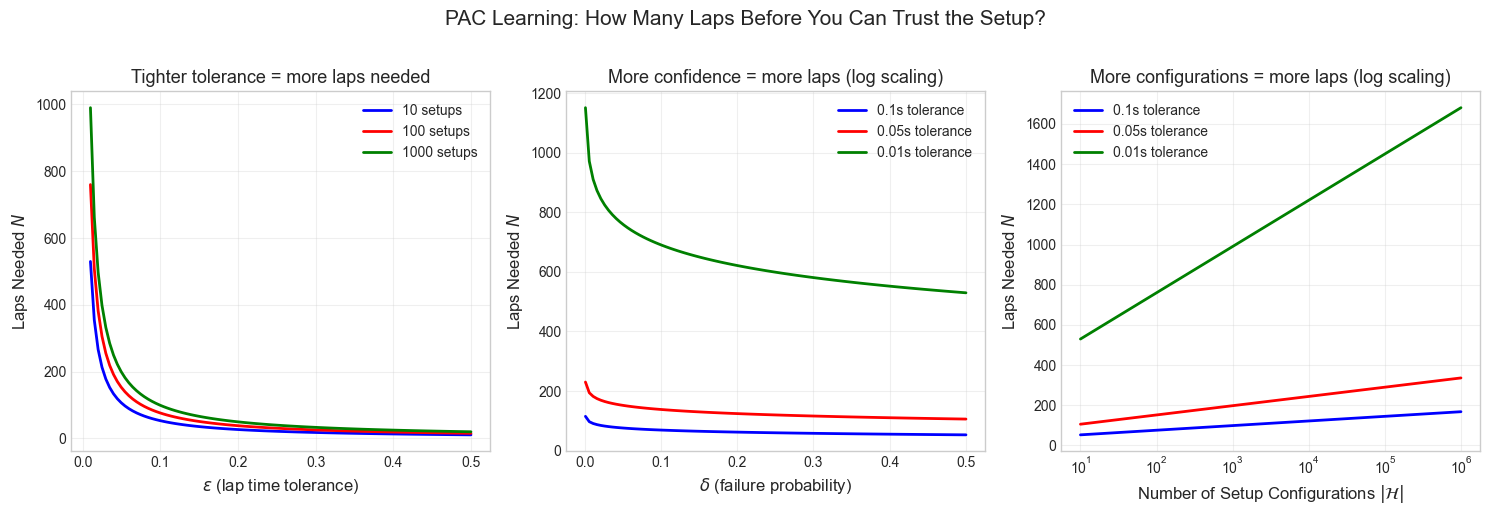

Example: To get within 5% of optimal with 95% confidence
  choosing among 1000 setup configurations, you need N >= 199 laps


In [13]:
# Visualize PAC sample complexity — "How many laps do we need?"
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Laps needed vs accuracy tolerance
ax = axes[0]
epsilon = np.linspace(0.01, 0.5, 100)
for H_size, color, label in [(10, 'blue', '10 setups'), (100, 'red', '100 setups'), (1000, 'green', '1000 setups')]:
    delta = 0.05
    N_pac = (1/epsilon) * (np.log(H_size) + np.log(1/delta))
    ax.plot(epsilon, N_pac, color=color, linewidth=2, label=label)
ax.set_xlabel('$\epsilon$ (lap time tolerance)', fontsize=12)
ax.set_ylabel('Laps Needed $N$', fontsize=12)
ax.set_title('Tighter tolerance = more laps needed', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Laps needed vs confidence level
ax = axes[1]
delta = np.linspace(0.001, 0.5, 100)
for eps, color, label in [(0.1, 'blue', '0.1s tolerance'), (0.05, 'red', '0.05s tolerance'), (0.01, 'green', '0.01s tolerance')]:
    H_size = 100
    N_pac = (1/eps) * (np.log(H_size) + np.log(1/delta))
    ax.plot(delta, N_pac, color=color, linewidth=2, label=label)
ax.set_xlabel('$\delta$ (failure probability)', fontsize=12)
ax.set_ylabel('Laps Needed $N$', fontsize=12)
ax.set_title('More confidence = more laps (log scaling)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Laps needed vs number of setup configurations
ax = axes[2]
H_sizes = np.logspace(1, 6, 100)
for eps, color, label in [(0.1, 'blue', '0.1s tolerance'), (0.05, 'red', '0.05s tolerance'), (0.01, 'green', '0.01s tolerance')]:
    delta = 0.05
    N_pac = (1/eps) * (np.log(H_sizes) + np.log(1/delta))
    ax.semilogx(H_sizes, N_pac, color=color, linewidth=2, label=label)
ax.set_xlabel('Number of Setup Configurations $|\mathcal{H}|$', fontsize=12)
ax.set_ylabel('Laps Needed $N$', fontsize=12)
ax.set_title('More configurations = more laps (log scaling)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('PAC Learning: How Many Laps Before You Can Trust the Setup?', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# Concrete F1 example
epsilon = 0.05
delta = 0.05
H_size = 1000
N_required = int(np.ceil((1/epsilon) * (np.log(H_size) + np.log(1/delta))))
print(f"Example: To get within {epsilon:.0%} of optimal with {1-delta:.0%} confidence")
print(f"  choosing among {H_size} setup configurations, you need N >= {N_required} laps")

### Deep Dive: What PAC Learning Tells Us About ML

PAC learning provides the theoretical foundation for understanding *learnability*:

**A concept class is PAC-learnable** if there exists an algorithm that, for any $\epsilon > 0$ and $\delta > 0$, can learn a hypothesis with error $\leq \epsilon$ with probability $\geq 1 - \delta$, using a number of samples polynomial in $1/\epsilon$, $1/\delta$, and the model size.

**Key takeaways for practitioners:**

1. **Logarithmic dependence on $|\mathcal{H}|$ and $1/\delta$** — making your model 10x more complex only increases data needs by $\ln(10) \approx 2.3$. That's surprisingly cheap!

2. **Linear dependence on $1/\epsilon$** — going from 90% to 99% accuracy is much harder than 50% to 90%.

3. **Connection to VC dimension**: For infinite hypothesis classes (like neural networks), replace $\ln|\mathcal{H}|$ with $d_{VC}$ to get similar bounds.

**F1 insight:** This explains why teams can test relatively few setup configurations and still find a good one. The logarithmic dependence on $|\mathcal{H}|$ means that even with thousands of possible configurations, you only need modestly more data than if you had ten. The hard part is the *accuracy* requirement — getting within a tenth of a second of optimal requires dramatically more laps than getting within half a second.

**Why this matters:** PAC theory tells us that learning *is* possible with finite data — not something obvious from first principles. It also tells us the fundamental resource tradeoffs.

---
## 7. Regularization Theory

### Intuitive Explanation

Regularization adds a penalty to the loss function to prevent overfitting:

$$\text{Total Loss} = \text{Data Loss} + \lambda \cdot \text{Penalty}(w)$$

The two most common penalties:
- **L1 (Lasso):** $\|w\|_1 = \sum |w_i|$ — produces **sparse** solutions (many weights exactly zero)
- **L2 (Ridge):** $\|w\|_2^2 = \sum w_i^2$ — produces **small** weights (but rarely exactly zero)

### The F1 Connection

Regularization is **preventing setup over-specialization** — penalizing extreme settings that might work in one specific condition but fail everywhere else.

- **L1 regularization** = zeroing out unnecessary setup parameters. If a parameter isn't contributing meaningfully, set it to its default and stop wasting engineering time on it. This is like a team saying "we don't need to touch the differential setting for this track — leave it at baseline."
- **L2 regularization** = keeping all parameters in play but preventing any from being extreme. No single setting dominates — like a regulation that says "you can adjust everything, but nothing too aggressively." This produces balanced, predictable cars.

**Why does L1 give sparsity?** It's all about geometry. The L1 constraint region is a *diamond*, and the loss contours typically hit the diamond at a corner — where some coordinates are exactly zero. The L2 constraint region is a *sphere*, which has no corners, so the intersection point rarely has exact zeros.

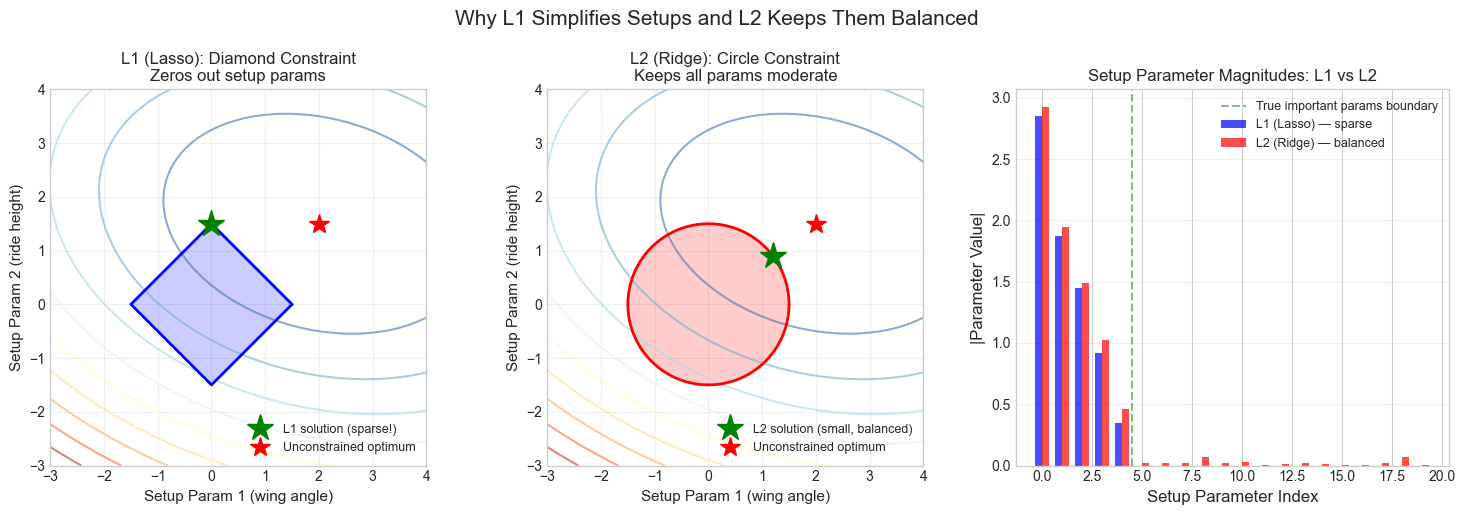

L1 (Lasso) non-zero setup params: 5/20
L2 (Ridge) non-zero setup params: 15/20


In [14]:
# The geometry of L1 vs L2 regularization — why sparsity happens
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create elliptical contours (represent lap time error surface)
theta_range = np.linspace(0, 2*np.pi, 200)

# Shifted center for the lap time error (unconstrained optimum)
center = np.array([2.0, 1.5])

# L1 constraint: |w1| + |w2| <= t (diamond boundary)
def l1_boundary(t):
    pts = []
    for th in np.linspace(0, 2*np.pi, 200):
        x = t * np.cos(th)
        y = t * np.sin(th)
        # Project onto L1 ball
        scale = (np.abs(x) + np.abs(y))
        if scale > 0:
            x, y = x * t / scale, y * t / scale
        pts.append([x, y])
    return np.array(pts)

# L2 constraint: w1^2 + w2^2 <= t^2 (circle boundary)
def l2_boundary(t):
    return np.column_stack([t * np.cos(theta_range), t * np.sin(theta_range)])

# Plot L1: Diamond forces setup params to corners (zeros!)
ax = axes[0]
A_loss = np.array([[1.0, 0.3], [0.3, 2.0]])
xx, yy = np.meshgrid(np.linspace(-3, 4, 200), np.linspace(-3, 4, 200))
zz = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        d = np.array([xx[i,j], yy[i,j]]) - center
        zz[i,j] = 0.5 * d @ A_loss @ d

ax.contour(xx, yy, zz, levels=10, cmap='RdYlBu_r', alpha=0.6)

# Diamond (L1 ball) — "only adjust a few things"
t = 1.5
diamond = np.array([[t, 0], [0, t], [-t, 0], [0, -t], [t, 0]])
ax.fill(diamond[:, 0], diamond[:, 1], alpha=0.2, color='blue')
ax.plot(diamond[:, 0], diamond[:, 1], 'b-', linewidth=2)

# Mark the solution (corner of diamond — one param zeroed!)
ax.plot(0, t, 'g*', markersize=20, zorder=5, label='L1 solution (sparse!)')
ax.plot(center[0], center[1], 'r*', markersize=15, label='Unconstrained optimum')

ax.set_title('L1 (Lasso): Diamond Constraint\nZeros out setup params', fontsize=12)
ax.set_xlabel('Setup Param 1 (wing angle)', fontsize=11)
ax.set_ylabel('Setup Param 2 (ride height)', fontsize=11)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 4)
ax.set_aspect('equal')
ax.legend(fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)

# Plot L2: Circle keeps all params but small
ax = axes[1]
ax.contour(xx, yy, zz, levels=10, cmap='RdYlBu_r', alpha=0.6)

# Circle (L2 ball) — "keep everything moderate"
circle_pts = l2_boundary(t)
ax.fill(circle_pts[:, 0], circle_pts[:, 1], alpha=0.2, color='red')
ax.plot(circle_pts[:, 0], circle_pts[:, 1], 'r-', linewidth=2)

# Mark the solution (on circle, not at corner)
setup_l2 = center / np.linalg.norm(center) * t
ax.plot(setup_l2[0], setup_l2[1], 'g*', markersize=20, zorder=5, label='L2 solution (small, balanced)')
ax.plot(center[0], center[1], 'r*', markersize=15, label='Unconstrained optimum')

ax.set_title('L2 (Ridge): Circle Constraint\nKeeps all params moderate', fontsize=12)
ax.set_xlabel('Setup Param 1 (wing angle)', fontsize=11)
ax.set_ylabel('Setup Param 2 (ride height)', fontsize=11)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 4)
ax.set_aspect('equal')
ax.legend(fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)

# Plot comparison of setup parameter magnitudes
ax = axes[2]
np.random.seed(42)
n_setup_params = 20
X_reg = np.random.randn(100, n_setup_params)
setup_true_reg = np.zeros(n_setup_params)
setup_true_reg[:5] = [3, -2, 1.5, -1, 0.5]  # Only 5 params actually matter
y_reg = X_reg @ setup_true_reg + 0.3 * np.random.randn(100)

# Fit models
from sklearn.linear_model import Lasso, Ridge
lasso = Lasso(alpha=0.1).fit(X_reg, y_reg)
ridge = Ridge(alpha=1.0).fit(X_reg, y_reg)

x_pos = np.arange(n_setup_params)
width = 0.35
ax.bar(x_pos - width/2, np.abs(lasso.coef_), width, color='blue', alpha=0.7, label='L1 (Lasso) — sparse')
ax.bar(x_pos + width/2, np.abs(ridge.coef_), width, color='red', alpha=0.7, label='L2 (Ridge) — balanced')
ax.axvline(x=4.5, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='True important params boundary')
ax.set_xlabel('Setup Parameter Index', fontsize=12)
ax.set_ylabel('|Parameter Value|', fontsize=12)
ax.set_title('Setup Parameter Magnitudes: L1 vs L2', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Why L1 Simplifies Setups and L2 Keeps Them Balanced', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

print(f"L1 (Lasso) non-zero setup params: {np.sum(np.abs(lasso.coef_) > 0.01)}/{n_setup_params}")
print(f"L2 (Ridge) non-zero setup params: {np.sum(np.abs(ridge.coef_) > 0.01)}/{n_setup_params}")

<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/587251588.py:21: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ (regularization strength)', fontsize=12)
/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_7266/587251588.py:42: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ (regularization strength)', fontsize=12)


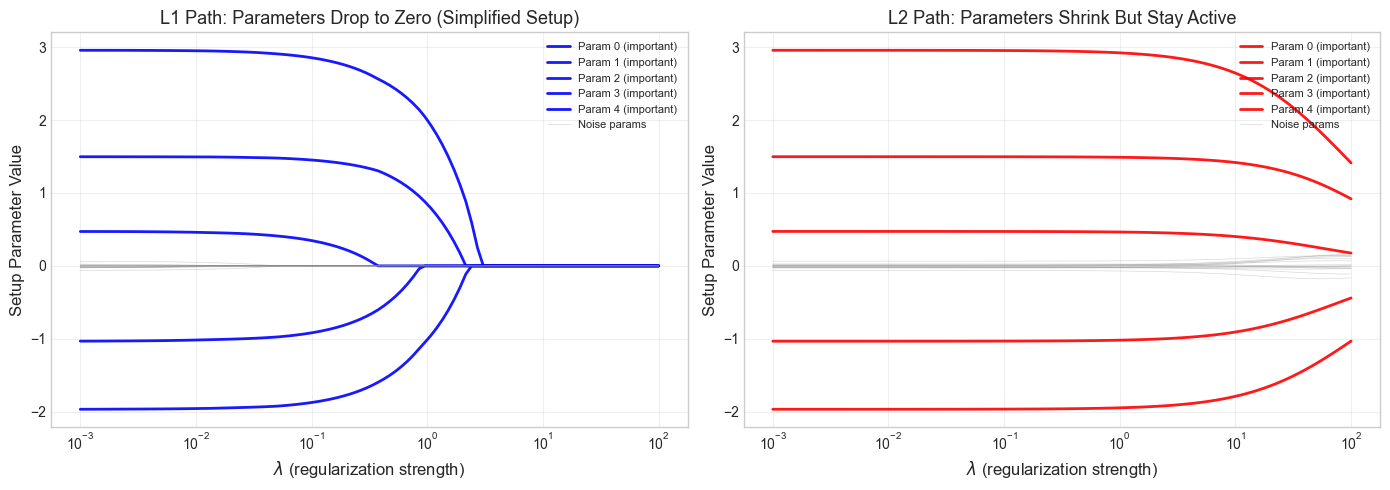

Key observation:
  L1: Setup params drop to EXACTLY zero as penalty increases (parameter selection!)
  L2: Setup params shrink smoothly toward zero but never reach it


In [15]:
# Regularization paths: how setup parameters change with penalty strength
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = np.logspace(-3, 2, 100)

# Lasso path — parameters get zeroed out as penalty increases
lasso_coefs = []
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_reg, y_reg)
    lasso_coefs.append(model.coef_.copy())
lasso_coefs = np.array(lasso_coefs)

ax = axes[0]
for j in range(n_setup_params):
    color = 'blue' if j < 5 else 'gray'
    alpha_val = 0.9 if j < 5 else 0.3
    linewidth = 2 if j < 5 else 0.5
    label = f'Param {j} (important)' if j < 5 else (None if j > 5 else 'Noise params')
    ax.semilogx(alphas, lasso_coefs[:, j], color=color, alpha=alpha_val, linewidth=linewidth, label=label)
ax.set_xlabel('$\lambda$ (regularization strength)', fontsize=12)
ax.set_ylabel('Setup Parameter Value', fontsize=12)
ax.set_title('L1 Path: Parameters Drop to Zero (Simplified Setup)', fontsize=13)
ax.legend(fontsize=8, loc='upper right')
ax.grid(True, alpha=0.3)

# Ridge path — parameters shrink but never reach zero
ridge_coefs = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_reg, y_reg)
    ridge_coefs.append(model.coef_.copy())
ridge_coefs = np.array(ridge_coefs)

ax = axes[1]
for j in range(n_setup_params):
    color = 'red' if j < 5 else 'gray'
    alpha_val = 0.9 if j < 5 else 0.3
    linewidth = 2 if j < 5 else 0.5
    label = f'Param {j} (important)' if j < 5 else (None if j > 5 else 'Noise params')
    ax.semilogx(alphas, ridge_coefs[:, j], color=color, alpha=alpha_val, linewidth=linewidth, label=label)
ax.set_xlabel('$\lambda$ (regularization strength)', fontsize=12)
ax.set_ylabel('Setup Parameter Value', fontsize=12)
ax.set_title('L2 Path: Parameters Shrink But Stay Active', fontsize=13)
ax.legend(fontsize=8, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observation:")
print("  L1: Setup params drop to EXACTLY zero as penalty increases (parameter selection!)")
print("  L2: Setup params shrink smoothly toward zero but never reach it")

### Deep Dive: Regularization as Bayesian Priors

There's a beautiful connection between regularization and Bayesian statistics:

| Regularizer | Equivalent Prior | Distribution | F1 Parallel |
|------------|-----------------|--------------|-------------|
| L2 (Ridge) | Gaussian prior: $w_i \sim \mathcal{N}(0, 1/\lambda)$ | Weights cluster near zero | "All setup params should be near baseline" |
| L1 (Lasso) | Laplace prior: $w_i \sim \text{Laplace}(0, 1/\lambda)$ | Weights sparse (peak at zero) | "Most setup params don't matter — find the few that do" |
| Elastic Net | Mix of Gaussian + Laplace | Best of both worlds | "Find important params, keep them moderate" |

**What this means:** When you add L2 regularization, you're saying "I believe the weights are probably small." When you add L1, you're saying "I believe most weights are probably zero." The strength $\lambda$ controls how strongly you hold this belief.

**F1 analogy:** An experienced race engineer has strong priors — they know that for most circuits, ride height and wing angle matter most, while obscure differential settings rarely make a big difference. A rookie engineer with no priors might waste time optimizing parameters that don't matter. Regularization encodes this experience mathematically.

**Elastic Net** combines both:
$$\text{Penalty} = \alpha \|w\|_1 + (1-\alpha) \|w\|_2^2$$

This gives sparsity (from L1) while handling correlated features better (from L2).

#### Key Insight

Regularization is not a "trick" — it's a principled way of encoding prior knowledge about what good solutions look like. Every regularizer implicitly answers the question: "What kind of models do I expect to work well?" 

---
## 8. Why Overparameterized Networks Generalize

### Intuitive Explanation

Classical learning theory says: more parameters → more overfitting. But modern neural networks have *millions* of parameters (far more than training examples) and still generalize beautifully. This contradicts classical theory and is one of the deepest open questions in ML.

**The double descent phenomenon:** As model complexity increases, test error follows a U-shape (classical regime), but then *decreases again* after the interpolation threshold (where the model can perfectly fit the training data).

### The F1 Connection

Think of this as the **paradox of large teams**. Classical theory says a 3-person pit crew should be more "efficient" than a 20-person crew — fewer people to coordinate, fewer things to go wrong. But in practice, the 20-person Red Bull pit crew does 2-second stops. Why? Because having more people means each person can specialize, and the crew self-organizes into an efficient sub-structure. The "extra" crew members aren't wasted — they enable the specialization that makes the whole operation faster.

Similarly, overparameterized networks have far more parameters than they "need" in theory, but the extra capacity allows SGD to find elegant, simple solutions within the vast solution space.

Three key ideas explain why overparameterization works:

1. **Double descent**: The classical bias-variance tradeoff is incomplete — it misses the "modern" regime
2. **Implicit regularization**: SGD, by its nature, finds "simple" solutions among the many that fit the data
3. **Lottery ticket hypothesis**: Large networks contain small subnetworks that do most of the work

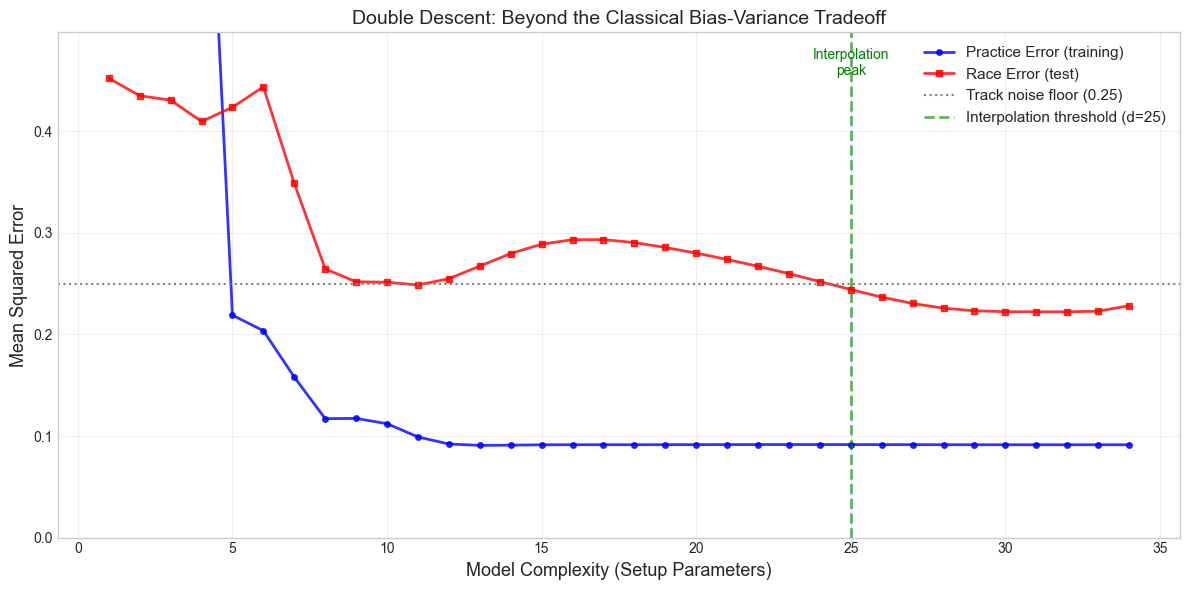

Double descent: race error peaks at the interpolation threshold,
then DECREASES as the model becomes even more overparameterized!


In [16]:
# Simulate the double descent curve — the surprise of overparameterization
np.random.seed(42)

# Generate lap time data from a moderately complex relationship
n_total = 40
x_all = np.linspace(0, 1, n_total)
laptime_fn = lambda x: np.sin(4 * np.pi * x) + 0.5 * np.cos(6 * np.pi * x)
track_noise = 0.5

n_practice = 25
indices = np.random.choice(n_total, n_practice, replace=False)
x_practice_dd = x_all[indices]
y_practice_dd = laptime_fn(x_practice_dd) + track_noise * np.random.randn(n_practice)
mask = np.ones(n_total, dtype=bool)
mask[indices] = False
x_race_dd = x_all[mask]
y_race_dd = laptime_fn(x_race_dd) + track_noise * np.random.randn(n_total - n_practice)

# Fit models of increasing complexity, including overparameterized
complexities_dd = list(range(1, 35))
practice_errors_dd = []
race_errors_dd = []

for d in complexities_dd:
    poly = PolynomialFeatures(d)
    X_pr = poly.fit_transform(x_practice_dd.reshape(-1, 1))
    X_rc = poly.transform(x_race_dd.reshape(-1, 1))

    # Use Ridge with tiny regularization for numerical stability past interpolation
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=1e-10)
    model.fit(X_pr, y_practice_dd)

    y_pred_pr = model.predict(X_pr)
    y_pred_rc = model.predict(X_rc)

    practice_errors_dd.append(np.mean((y_pred_pr - y_practice_dd)**2))
    race_errors_dd.append(np.clip(np.mean((y_pred_rc - y_race_dd)**2), 0, 15))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(complexities_dd, practice_errors_dd, 'b-o', linewidth=2, markersize=4, label='Practice Error (training)', alpha=0.8)
ax.plot(complexities_dd, race_errors_dd, 'r-s', linewidth=2, markersize=4, label='Race Error (test)', alpha=0.8)
ax.axhline(y=track_noise**2, color='gray', linestyle=':', linewidth=1.5, label=f'Track noise floor ({track_noise**2:.2f})')
ax.axvline(x=n_practice, color='green', linestyle='--', linewidth=2, alpha=0.6,
           label=f'Interpolation threshold (d={n_practice})')

# Annotate regions
ax.annotate('Classical\nregime', xy=(8, 1), fontsize=12, color='blue',
            ha='center', fontweight='bold')
ax.annotate('Modern\n(overparameterized)\nregime', xy=(30, 1), fontsize=12, color='red',
            ha='center', fontweight='bold')
ax.annotate('Interpolation\npeak', xy=(n_practice, max(race_errors_dd)), fontsize=10, color='green',
            ha='center', va='bottom')

ax.set_xlabel('Model Complexity (Setup Parameters)', fontsize=13)
ax.set_ylabel('Mean Squared Error', fontsize=13)
ax.set_title('Double Descent: Beyond the Classical Bias-Variance Tradeoff', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim(0, min(15, max(race_errors_dd) * 1.1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Double descent: race error peaks at the interpolation threshold,")
print("then DECREASES as the model becomes even more overparameterized!")

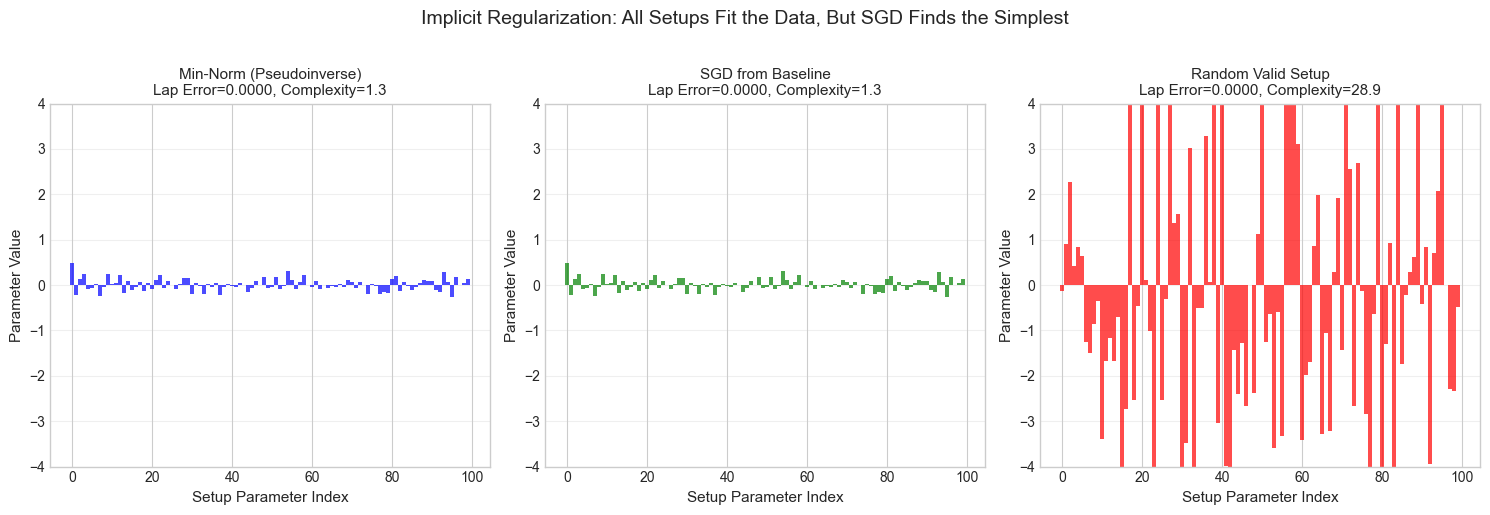

Setup complexity (L2 norm):
  Min-norm:  ||setup|| = 1.3063
  SGD:       ||setup|| = 1.3063
  Random:    ||setup|| = 28.9465

All have near-zero lap errors — but the complexities are very different!
SGD implicitly finds a setup close to the minimum-norm solution.


In [17]:
# Demonstrate implicit regularization: SGD finds the simplest setup among many valid ones
np.random.seed(42)

# Underdetermined system: more setup parameters than data points
n_laps_imp = 20
n_params_imp = 100  # Way more parameters than laps — overparameterized!

X_imp = np.random.randn(n_laps_imp, n_params_imp)
setup_target = np.zeros(n_params_imp)
setup_target[:5] = np.array([2, -1, 0.5, 1.5, -0.8])  # Sparse true setup
y_imp = X_imp @ setup_target + 0.1 * np.random.randn(n_laps_imp)

# Many solutions exist! Let's see what different methods find.

# Method 1: Minimum-norm solution (pseudoinverse) — simplest mathematically
setup_minnorm = X_imp.T @ np.linalg.solve(X_imp @ X_imp.T, y_imp)

# Method 2: SGD from baseline (zero initialization) — implicit regularization at work
setup_sgd = np.zeros(n_params_imp)
sgd_rate = 0.001
for session in range(1000):
    for i in np.random.permutation(n_laps_imp):
        xi = X_imp[i:i+1]
        yi = y_imp[i:i+1]
        grad = 2 * xi.T @ (xi @ setup_sgd - yi)
        setup_sgd = setup_sgd - sgd_rate * grad.flatten()

# Method 3: Random valid solution (fits data but is unnecessarily complex)
setup_particular = setup_minnorm
null_component = np.random.randn(n_params_imp)
# Project onto null space of X
proj = X_imp.T @ np.linalg.solve(X_imp @ X_imp.T, X_imp)
null_component = null_component - proj @ null_component
setup_random = setup_particular + 3 * null_component  # Add large null space component

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = [
    ('Min-Norm (Pseudoinverse)', setup_minnorm, 'blue'),
    ('SGD from Baseline', setup_sgd, 'green'),
    ('Random Valid Setup', setup_random, 'red')
]

for ax, (name, setup, color) in zip(axes, methods):
    ax.bar(range(n_params_imp), setup, color=color, alpha=0.7, width=1.0)
    ax.set_xlabel('Setup Parameter Index', fontsize=11)
    ax.set_ylabel('Parameter Value', fontsize=11)
    lap_error = np.mean((X_imp @ setup - y_imp)**2)
    setup_complexity = np.linalg.norm(setup)
    ax.set_title(f'{name}\nLap Error={lap_error:.4f}, Complexity={setup_complexity:.1f}', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-4, 4)

plt.suptitle('Implicit Regularization: All Setups Fit the Data, But SGD Finds the Simplest',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Setup complexity (L2 norm):")
print(f"  Min-norm:  ||setup|| = {np.linalg.norm(setup_minnorm):.4f}")
print(f"  SGD:       ||setup|| = {np.linalg.norm(setup_sgd):.4f}")
print(f"  Random:    ||setup|| = {np.linalg.norm(setup_random):.4f}")
print(f"\nAll have near-zero lap errors — but the complexities are very different!")
print(f"SGD implicitly finds a setup close to the minimum-norm solution.")

### Deep Dive: The Lottery Ticket Hypothesis

The **Lottery Ticket Hypothesis** (Frankle & Carlin, 2019) proposes:

> A randomly initialized, dense neural network contains a subnetwork (a "winning ticket") that — when trained in isolation — reaches comparable accuracy to the full network in a similar number of training steps.

**F1 analogy:** Think of a large F1 team's engineering department. Out of 800+ employees, there's a core group — the "winning ticket" — whose contributions account for most of the car's performance gains. You could theoretically achieve 90%+ of the performance with a much smaller team, but you need the large team to *discover* who those key contributors are.

**What this means:**
- Large networks work well not because all parameters are needed, but because having many parameters increases the chance of containing a good subnetwork
- You can prune 90%+ of weights after training with minimal accuracy loss
- The initial random values of the winning ticket matter — it's the specific initialization that makes it trainable

**Why this is profound:**
1. It suggests most parameters in large networks are "wasted" at inference time
2. It explains why overparameterization helps *training* even if not needed for *representation*
3. It motivates network pruning and efficient inference

#### Open Questions (Honest Assessment)

| Question | Current Understanding |
|----------|---------------------|
| Why does SGD find flat minima? | Partially understood — noise scale matters |
| Is double descent universal? | Observed broadly, but theory is incomplete |
| Can we find winning tickets cheaply? | Active research; training is still needed to identify them |
| Why do large models generalize at all? | Multiple competing theories; no consensus yet |

**The honest truth:** We don't fully understand why deep learning works as well as it does. The theory is catching up to the practice, and that's what makes this field exciting.

---
## Exercises

### Exercise 1: Implement Setup Optimization with Momentum

In F1, momentum in setup changes means **keeping adjustments going in the direction that's been working**. If lowering the front wing improved the car in FP1 and FP2, momentum says "keep going that direction" even if one noisy lap suggests otherwise.

Mathematically, momentum accelerates GD by accumulating a velocity vector:

$$v_{t+1} = \beta v_t + \nabla f(x_t)$$
$$x_{t+1} = x_t - \eta v_{t+1}$$

Implement this and compare convergence with vanilla GD on an ill-conditioned setup surface (where the car is much more sensitive to one parameter than another).

In [18]:
# EXERCISE 1: Implement setup optimization with momentum
def setup_optimization_momentum(grad_f, setup0, setup_rate, n_sessions, momentum_coeff=0.9, f=None):
    """
    Gradient descent with momentum for car setup optimization.

    Args:
        grad_f: Gradient function (telemetry feedback)
        setup0: Initial car setup
        setup_rate: How aggressively to change setup
        n_sessions: Number of practice iterations
        momentum_coeff: Momentum coefficient — how much to trust the previous direction (default 0.9)
        f: Optional objective function (lap time error) for tracking

    Returns:
        history dict with setup trajectory and lap time errors
    """
    setup = np.array(setup0, dtype=float)
    velocity = np.zeros_like(setup)  # Initialize momentum velocity
    history = {'x': [setup.copy()], 'f': []}

    if f is not None:
        history['f'].append(f(setup))

    for t in range(n_sessions):
        # TODO: Implement momentum update
        # Hint: First update velocity, then update setup
        # velocity = momentum_coeff * velocity + grad_f(setup)
        # setup = setup - setup_rate * velocity

        pass  # Replace with your implementation

        history['x'].append(setup.copy())
        if f is not None:
            history['f'].append(f(setup))

    history['x'] = np.array(history['x'])
    return history

# Test on an ill-conditioned setup surface (car very sensitive to one param)
A_unbalanced = np.array([[20.0, 0.0], [0.0, 1.0]])  # condition number = 20
f_unbalanced, grad_unbalanced = make_quadratic(A_unbalanced)
setup0_test = np.array([5.0, 5.0])

# Test your implementation
hist_momentum = setup_optimization_momentum(grad_unbalanced, setup0_test, setup_rate=0.05, n_sessions=100, momentum_coeff=0.9, f=f_unbalanced)
hist_vanilla = gradient_descent(grad_unbalanced, setup0_test, 0.05, 100, f=f_unbalanced)

# Verify
if len(hist_momentum['f']) > 1 and hist_momentum['f'][-1] != hist_momentum['f'][0]:
    print(f"Momentum final lap time error:  {hist_momentum['f'][-1]:.6f}")
    print(f"Vanilla final lap time error:   {hist_vanilla['f'][-1]:.6f}")
    print(f"Momentum converges faster: {hist_momentum['f'][-1] < hist_vanilla['f'][-1]}")
else:
    print("TODO: Implement the momentum update in the loop above!")
    print("Expected: Momentum should converge significantly faster than vanilla GD")
    print(f"Vanilla GD final lap time error: {hist_vanilla['f'][-1]:.6f}")

TODO: Implement the momentum update in the loop above!
Expected: Momentum should converge significantly faster than vanilla GD
Vanilla GD final lap time error: 0.000438


### Exercise 2: Cross-Validation for Lap Time Model Selection

An F1 team needs to choose the right complexity for their lap time prediction model. Too simple and it misses important patterns (underfitting). Too complex and it memorizes noise from one specific session (overfitting).

Use cross-validation to find the best polynomial degree for predicting lap times from a noisy dataset. This connects the bias-variance tradeoff to practical model selection — exactly the decision teams face when choosing between a simple "track-type" model vs. a detailed telemetry-based simulator.

In [19]:
# EXERCISE 2: Find the best lap time model complexity using cross-validation
np.random.seed(42)

# Generate lap time data (e.g., lap time vs fuel load or track position)
n_laps_cv = 100
x_cv = np.random.uniform(0, 2*np.pi, n_laps_cv)
y_cv = np.sin(x_cv) + 0.3 * np.cos(3*x_cv) + 0.4 * np.random.randn(n_laps_cv)

def evaluate_laptime_model(x, y, complexity, cv_folds=5):
    """
    Evaluate a polynomial lap time model using cross-validation.

    Args:
        x: Input features (1D array — e.g., fuel load or track position)
        y: Target lap times
        complexity: Polynomial degree to evaluate
        cv_folds: Number of cross-validation folds (like testing across different sessions)

    Returns:
        mean_cv_score: Mean cross-validation score (negative MSE)
    """
    # TODO: Implement this!
    # Hint:
    # 1. Create polynomial features: PolynomialFeatures(complexity)
    # 2. Transform x: poly.fit_transform(x.reshape(-1, 1))
    # 3. Use cross_val_score with LinearRegression and scoring='neg_mean_squared_error'
    # 4. Return the mean score

    pass  # Replace with your implementation

# Test all complexities from 1 to 15
complexities_cv = range(1, 16)
cv_scores = []

for d in complexities_cv:
    score = evaluate_laptime_model(x_cv, y_cv, d)
    if score is not None:
        cv_scores.append(-score)  # Negate because sklearn returns negative MSE
    else:
        cv_scores.append(None)

if cv_scores[0] is not None:
    best_complexity = complexities_cv[np.argmin(cv_scores)]
    print(f"Best lap time model complexity by CV: degree {best_complexity}")
    print(f"CV MSE scores: {[f'{s:.4f}' for s in cv_scores]}")

    # Verify
    expected_best = 4  # Approximate expected best (sin + cos terms)
    print(f"\nExpected best degree: around {expected_best}")
    print(f"Your best degree: {best_complexity}")
    print(f"Reasonable: {1 <= best_complexity <= 7}")
else:
    print("TODO: Implement evaluate_laptime_model above!")
    print("Expected: Best degree should be around 3-5 (matching the true function complexity)")

TODO: Implement evaluate_laptime_model above!
Expected: Best degree should be around 3-5 (matching the true function complexity)


### Exercise 3: Compare Setup Regularization Strategies

An F1 car has 30 adjustable setup parameters, but only about 8 truly matter for lap time at a given circuit. The rest are noise or have minimal impact.

Compare L1 (Lasso), L2 (Ridge), and Elastic Net regularization to see which best recovers the true sparse structure — i.e., which method correctly identifies the important setup parameters and ignores the irrelevant ones. This is the setup engineering equivalent of "which parameters should we spend time optimizing?"

In [20]:
# EXERCISE 3: Setup regularization comparison
np.random.seed(42)

# Create dataset: 30 setup parameters, only 8 actually affect lap time
n_laps_ex, n_setup_ex = 80, 30
X_ex = np.random.randn(n_laps_ex, n_setup_ex)
setup_true_ex = np.zeros(n_setup_ex)
setup_true_ex[:8] = [4, -3, 2, -1.5, 1, -0.5, 3, -2]  # Only 8 params matter
y_ex = X_ex @ setup_true_ex + 0.5 * np.random.randn(n_laps_ex)

def compare_setup_regularizers(X, y, setup_true, alpha_l1=0.5, alpha_l2=1.0, l1_ratio=0.5):
    """
    Compare L1, L2, and Elastic Net regularization for setup parameter recovery.

    Args:
        X: Telemetry feature matrix
        y: Lap time targets
        setup_true: True setup parameter values (for comparison)
        alpha_l1: Regularization strength for Lasso
        alpha_l2: Regularization strength for Ridge
        l1_ratio: L1 ratio for Elastic Net

    Returns:
        dict with 'lasso', 'ridge', 'elastic_net' entries, each containing:
            'coef': fitted coefficients (recovered setup params)
            'n_nonzero': number of active parameters (|w| > 0.01)
            'mse': mean squared error of parameter recovery
    """
    results = {}

    # TODO: Implement this!
    # Hint:
    # 1. Fit Lasso(alpha=alpha_l1), Ridge(alpha=alpha_l2),
    #    and ElasticNet (from sklearn.linear_model import ElasticNet)
    # 2. For each, compute:
    #    - coef: model.coef_
    #    - n_nonzero: np.sum(np.abs(model.coef_) > 0.01)
    #    - mse: np.mean((model.coef_ - setup_true)**2)

    pass  # Replace with your implementation

    return results

# Test
results = compare_setup_regularizers(X_ex, y_ex, setup_true_ex)

if results:
    print("Setup Regularization Comparison:")
    print(f"{'Method':<15} {'Active Params':>15} {'Recovery MSE':>15} {'True Active':>15}")
    print("-" * 65)
    true_active = np.sum(np.abs(setup_true_ex) > 0.01)
    for name, res in results.items():
        print(f"{name:<15} {res['n_nonzero']:>15} {res['mse']:>15.4f} {true_active:>15}")

    # Verify
    print(f"\nExpected: Lasso should identify closest to {true_active} active parameters")
    print(f"Expected: Ridge should keep ALL parameters active")
    print(f"Expected: Elastic Net should be in between")
else:
    print("TODO: Implement compare_setup_regularizers above!")
    print(f"True active setup parameters: {np.sum(np.abs(setup_true_ex) > 0.01)}")
    print("Expected: L1 finds the important params, L2 keeps all, Elastic Net balances both")

TODO: Implement compare_setup_regularizers above!
True active setup parameters: 8
Expected: L1 finds the important params, L2 keeps all, Elastic Net balances both


### Exercise 4 (Bonus): Setup Change Rate Schedules

Just like F1 teams make **big setup changes in FP1** and progressively **fine-tune through FP3**, learning rate schedules reduce the step size over training.

Implement and compare three setup change rate schedules for SGD:
1. **Constant**: $\eta_t = \eta_0$ (same aggressiveness every session)
2. **Step decay**: $\eta_t = \eta_0 \cdot 0.5^{\lfloor t/50 \rfloor}$ (halve aggressiveness periodically)
3. **Cosine annealing**: $\eta_t = \eta_0 \cdot \frac{1}{2}\left(1 + \cos\left(\frac{\pi t}{T}\right)\right)$ (smooth transition from aggressive to cautious)

In [21]:
# EXERCISE 4 (BONUS): Setup change rate schedules
np.random.seed(42)

def rate_constant(t, rate0=0.01):
    """Constant rate — same aggressiveness every session."""
    return rate0

def rate_step_decay(t, rate0=0.01, drop_rate=0.5, drop_every=50):
    """Step decay: halve aggressiveness every drop_every sessions."""
    # TODO: Implement this
    # Hint: return rate0 * drop_rate ** (t // drop_every)
    pass

def rate_cosine(t, rate0=0.01, T=200):
    """Cosine annealing: smooth transition from aggressive to cautious."""
    # TODO: Implement this
    # Hint: return rate0 * 0.5 * (1 + np.cos(np.pi * t / T))
    pass

# Compare on the lap time prediction problem from Section 3
schedules = {
    'Constant': rate_constant,
    'Step Decay': rate_step_decay,
    'Cosine Annealing': rate_cosine
}

n_sessions_sched = 200

for name, schedule in schedules.items():
    if schedule is None or schedule(0) is None:
        print(f"TODO: Implement {name} schedule")
        continue
    np.random.seed(42)
    hist = sgd(stint_grad, setup_init, schedule, n_sessions_sched, N, stint_size=16, f=full_lap_error)
    print(f"{name}: final lap time error = {hist['f'][-1]:.6f}")

print("\nExpected: Cosine annealing or step decay should outperform constant rate")

Constant: final lap time error = 0.091308
TODO: Implement Step Decay schedule
TODO: Implement Cosine Annealing schedule

Expected: Cosine annealing or step decay should outperform constant rate


---
## Summary

### Key Concepts

- **Gradient descent convergence** depends on convexity and the condition number. Strongly convex functions converge exponentially; convex functions converge as $O(1/t)$. In F1 terms: a well-understood, balanced car converges to optimal setup much faster than a car with unpredictable behavior.
- **Step size selection** is critical: too large causes divergence, too small wastes compute. The optimal step size is $\eta = 1/L$ where $L$ is the Lipschitz constant. Engineers who change setup too aggressively oscillate; too conservatively, they run out of sessions.
- **SGD** trades exact gradients for computational efficiency, and the noise provides implicit regularization that often improves generalization. Learning from individual laps (noisy but fast) often builds more robust setups than waiting for full session averages.
- **Bias-variance tradeoff** decomposes test error into underfitting (bias) and overfitting (variance). A conservative "works everywhere" setup has high bias; an over-specialized setup has high variance.
- **VC dimension** measures model capacity — the largest dataset a model class can perfectly memorize for any labeling. It quantifies how much complexity you need to predict lap times.
- **PAC learning** provides sample complexity bounds: how many laps you need for a given accuracy and confidence level.
- **L1 regularization** produces sparse solutions (zeroing out unimportant setup parameters) while **L2 regularization** produces small, balanced parameters. This follows from the geometry of their constraint regions.
- **Overparameterized networks** generalize better than classical theory predicts, due to implicit regularization, the double descent phenomenon, and the lottery ticket hypothesis.

### Connection to Machine Learning

| Concept | ML Application | Why It Matters | F1 Parallel |
|---------|---------------|----------------|-------------|
| Convergence rates | Learning rate tuning | Knowing the theory prevents trial-and-error | How fast the car converges to optimal setup across FP1-FP3 |
| Condition number | Feature normalization, BatchNorm | Explains why preprocessing helps | Car balance — unequal parameter sensitivity causes zigzag convergence |
| SGD noise | Generalization, escaping local minima | Why SGD often beats full-batch GD | Learning from individual laps builds more robust setups |
| Bias-variance | Model selection, hyperparameter tuning | The fundamental tradeoff in all of ML | Conservative vs specialized setup — safe but slow vs fast but fragile |
| VC dimension | Choosing model architecture | Capacity must match data complexity | How many telemetry channels you need to predict lap times |
| PAC learning | Dataset size requirements | How much data you actually need | How many laps before you can trust your setup |
| L1/L2 regularization | Dropout, weight decay, pruning | Most common tools against overfitting | Simplifying setup (L1) vs keeping it balanced (L2) |
| Double descent | Why large models work | Challenges classical "simpler is better" wisdom | Why large teams with "redundant" engineers outperform small ones |
| Lottery tickets | Network pruning, efficient inference | 90%+ of weights may be unnecessary | The core subteam doing most of the engineering work |

### Checklist

- [ ] I can explain why strongly convex functions converge faster than convex ones
- [ ] I can choose an appropriate learning rate given a function's properties
- [ ] I understand why SGD's noise is a feature, not a bug
- [ ] I can decompose test error into bias, variance, and irreducible noise
- [ ] I can explain what VC dimension measures and why it matters
- [ ] I can use PAC bounds to estimate required dataset sizes
- [ ] I understand geometrically why L1 gives sparsity (diamond vs sphere)
- [ ] I can explain the double descent curve and why overparameterization helps
- [ ] I know what the lottery ticket hypothesis claims and its implications

---
## Next Steps

In **Part 4.1: Perceptrons & Basic Networks** (Notebook 09), we shift from theory to building. You'll implement your first neural network from scratch — a single perceptron, then multi-layer networks with forward propagation and loss functions. The optimization theory from this notebook will come alive as you see gradient descent actually training a model.

**Key connections to look forward to:**
- Gradient descent (Sections 1-3) becomes the engine that trains every neural network — like the setup convergence process that runs every race weekend
- Regularization shows up as `weight_decay` parameters in optimizers — preventing the network from over-specializing, just like preventing extreme car setups
- Bias-variance tradeoff drives model architecture and hyperparameter choices — the same tension between conservative and aggressive setup philosophies
- SGD vs Adam (Section 3) becomes a practical choice you'll make in every training loop — full session analysis vs adaptive per-parameter optimization